In [17]:
# PARAMETERS
nc_file = "../output_archive/cloud_results_120mins.nc"
#nc_file = "../cloud_results.nc"
min_max_size_points = 100        # Track must reach at least this many voxels once
min_lifetime_steps = 3       # Track must exist (non-NaN size) at least this many timesteps
use_integrated_mass_flux = True  # If True: sum over time; else: time-mean
time_step_seconds = 60           # Needed only if you want to scale integrated flux by dt
volume_dx = 25.0                 # Horizontal grid (m)
volume_dy = 25.0                 # Horizontal grid (m)
# For voxel vertical thickness we infer per level (variable height spacing allowed)

# IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import seaborn as sns

# ---------------- Core extraction & processing ---------------- #
def load_tracks(nc_path):
    def read_opt(ds, name):
        var = ds.variables.get(name)
        if var is None:
            return None
            
        # Get the data as a masked array
        data = var[:]
        
        # Handle different data types appropriately
        if np.issubdtype(data.dtype, np.integer):
            # For integer arrays, convert to float64 to support NaN
            return np.ma.filled(data.astype(np.float64), np.nan)
        else:
            # For floating point arrays, use NaN directly
            return np.ma.filled(data, np.nan)
    

    with Dataset(nc_path) as ds:
        valid_track = np.asarray(ds.variables['valid_track'][:])
        size = np.ma.filled(ds.variables['size'][:], np.nan)
        mass_flux = np.ma.filled(ds.variables['mass_flux'][:], np.nan)
        merges_count = np.ma.filled(ds.variables['merges_count'][:], 0)
        splits_count = np.ma.filled(ds.variables['splits_count'][:], 0)
        height = np.asarray(ds.variables['height'][:])
        
        age = read_opt(ds, 'age') 
        cloud_base_area = read_opt(ds, 'cloud_base_area')
        max_height = read_opt(ds, 'max_height')
        cloud_base_height = read_opt(ds, 'cloud_base_height')
        base_radius_diagnosed = read_opt(ds, 'base_radius_diagnosed')
        base_radius_prescribed = read_opt(ds, 'base_radius_prescribed')
        max_w_cloud_base = read_opt(ds, 'max_w_cloud_base')
        w_per_level = read_opt(ds, 'w_per_level')  # (track,time,level)
        surface_area = read_opt(ds, 'surface_area')
        

    return dict(
        valid_track=valid_track,
        size=size,
        mass_flux=mass_flux,
        merges_count=merges_count.astype(np.int32),
        splits_count=splits_count.astype(np.int32),
        height=height,
        age=age,
        cloud_base_area=cloud_base_area,
        max_height=max_height,
        cloud_base_height=cloud_base_height,
        base_radius_diagnosed=base_radius_diagnosed,
        base_radius_prescribed=base_radius_prescribed,
        max_w_cloud_base=max_w_cloud_base,
        surface_area=surface_area,
        w_per_level=w_per_level,
    )






def build_track_dataframe(data, min_max_size_points, min_lifetime_steps,
                          use_integrated_mass_flux, time_step_seconds,
                          voxel_volume_per_level=None):
    valid_mask = data['valid_track'] == 1
    size = np.asarray(data['size'])                  # already filled
    mass_flux = np.asarray(data['mass_flux'])
    merges = np.asarray(data['merges_count'])
    splits = np.asarray(data['splits_count'])

    n_tracks, n_time = size.shape
    records = []
    for i in range(n_tracks):
        if not valid_mask[i]:
            continue

        size_row = size[i]  # (time,)
        # timesteps where size is real (not NaN and >0)
        valid_timesteps = np.isfinite(size_row)
        lifetime = int(valid_timesteps.sum())
        if lifetime == 0:
            continue

        max_size = np.nanmax(size_row)
        if (max_size < min_max_size_points) or (lifetime < min_lifetime_steps):
            continue

        # Safe sums (arrays are plain ndarrays now)
        merges_total = int(merges[i, valid_timesteps].sum())
        splits_total = int(splits[i, valid_timesteps].sum())

        mf_row = mass_flux[i]
        if use_integrated_mass_flux:
            mf_val = np.nansum(mf_row[valid_timesteps])  # * time_step_seconds if physical time integration needed
        else:
            mf_val = float(np.nanmean(mf_row[valid_timesteps]))

        mean_size = float(np.nanmean(size_row[valid_timesteps]))

        records.append(dict(track_index=i,
                            lifetime=lifetime,
                            max_size_points=max_size,
                            mean_size_points=mean_size,
                            merges_total=merges_total,
                            splits_total=splits_total,
                            mass_flux_metric=mf_val))
    return pd.DataFrame.from_records(records)


def infer_voxel_volumes(height, dx, dy):
    # Derive per-level thickness (Δz). Last level thickness = median of previous (fallback)
    z = np.asarray(height, dtype=float)
    if z.size < 2:
        dz = np.array([1.0])
    else:
        dz_mid = np.diff(z)
        last = np.median(dz_mid)
        dz = np.concatenate([dz_mid, [last]])
    # Return per-level voxel volume (m3)
    return dx * dy * dz


def categorize_merges(df):
    def cat(m):
        if m == 0: return "0"
        if m == 1: return "1"
        if m == 2: return "2"
        return "3+"
    return df.assign(merge_class=df.merges_total.map(cat),
                     merged_flag=(df.merges_total > 0))



# ---------------- Run pipeline ---------------- #
raw = load_tracks(nc_file)
voxel_vol = infer_voxel_volumes(raw['height'], volume_dx, volume_dy)  # still optional

df_tracks = build_track_dataframe(raw,
                                  min_max_size_points=min_max_size_points,
                                  min_lifetime_steps=min_lifetime_steps,
                                  use_integrated_mass_flux=use_integrated_mass_flux,
                                  time_step_seconds=time_step_seconds)

df_tracks = categorize_merges(df_tracks)


/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_37550/427141988.py:25: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(arr[idx, :], axis=1)


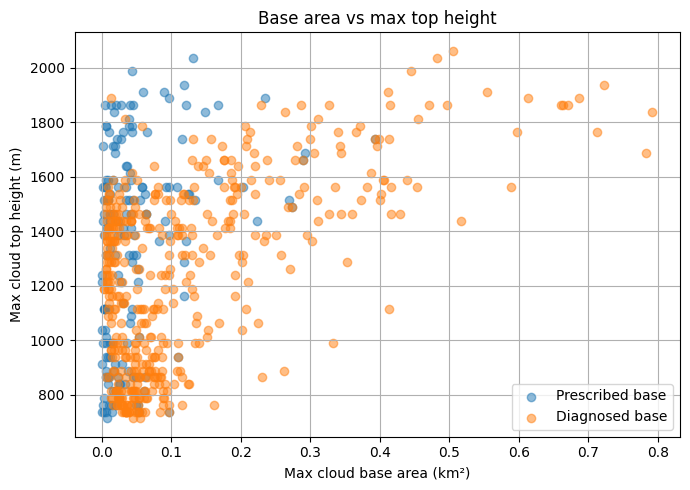

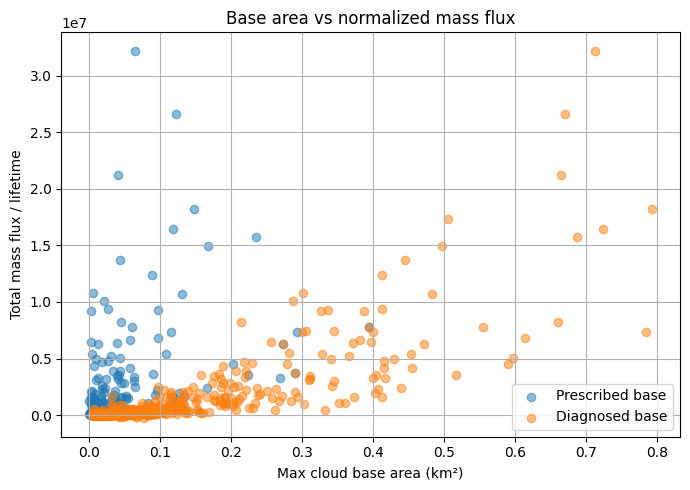

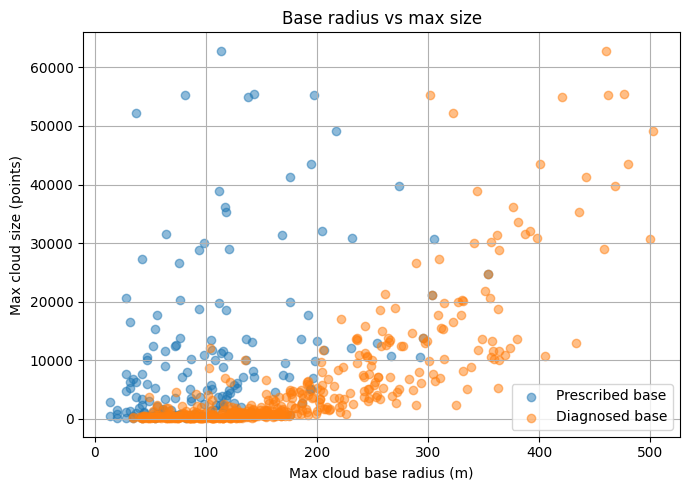

In [5]:
def extract_base_radii(raw, df_tracks):
    """
    Extract max prescribed and diagnosed base radii and top height for each track.
    Handles missing or malformed arrays gracefully.
    """
    # Defensive extraction
    prescribed = raw.get('base_radius_prescribed', None)
    diagnosed = raw.get('base_radius_diagnosed', None)
    top_height = raw.get('max_height', None)

    # Ensure arrays are present and have correct shape
    def safe_extract(arr, idx):
        if arr is None or not hasattr(arr, 'shape') or len(arr.shape) != 2:
            # Problem: array missing or not 2D
            # Risk: downstream IndexError, all NaN output
            # Fix: Return NaNs for all tracks
            return np.full(len(idx), np.nan)
        # Defensive: bounds check
        if arr.shape[0] < np.max(idx) + 1:
            # Problem: array too short for track indices
            # Risk: IndexError, incomplete extraction
            # Fix: Return NaNs for all tracks
            return np.full(len(idx), np.nan)
        # Extract max over time for each track
        return np.nanmax(arr[idx, :], axis=1)

    idx = df_tracks.track_index.values
    max_prescribed = safe_extract(prescribed, idx)
    max_diagnosed = safe_extract(diagnosed, idx)
    max_top_height = safe_extract(top_height, idx)
    return max_prescribed, max_diagnosed, max_top_height

max_prescribed, max_diagnosed, max_top_height = extract_base_radii(raw, df_tracks)

# Compute areas
area_prescribed = np.pi * max_prescribed**2 / 1e6  # convert to square km
area_diagnosed = np.pi * max_diagnosed**2 / 1e6

# Relationship 1: base area vs max cloud top height
plt.figure(figsize=(7,5))
plt.scatter(area_prescribed, max_top_height, alpha=0.5, label='Prescribed base')
plt.scatter(area_diagnosed, max_top_height, alpha=0.5, label='Diagnosed base')
plt.xlabel("Max cloud base area (km²)")
plt.ylabel("Max cloud top height (m)")
plt.title("Base area vs max top height")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Relationship 2: base area vs total mass flux (normalized by lifespan)
norm_mass_flux = df_tracks.mass_flux_metric / df_tracks.lifetime
plt.figure(figsize=(7,5))
plt.scatter(area_prescribed, norm_mass_flux, alpha=0.5, label='Prescribed base')
plt.scatter(area_diagnosed, norm_mass_flux, alpha=0.5, label='Diagnosed base')
plt.xlabel("Max cloud base area (km²)")
plt.ylabel("Total mass flux / lifetime")
plt.title("Base area vs normalized mass flux")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Relationship 3: base radius vs max size
plt.figure(figsize=(7,5))
plt.scatter(max_prescribed, df_tracks.max_size_points, alpha=0.5, label='Prescribed base')
plt.scatter(max_diagnosed, df_tracks.max_size_points, alpha=0.5, label='Diagnosed base')
plt.xlabel("Max cloud base radius (m)")
plt.ylabel("Max cloud size (points)")
plt.title("Base radius vs max size")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

## Some linear fits on the above. 

/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_14467/911454146.py:27: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(arr[idx, :], axis=1)


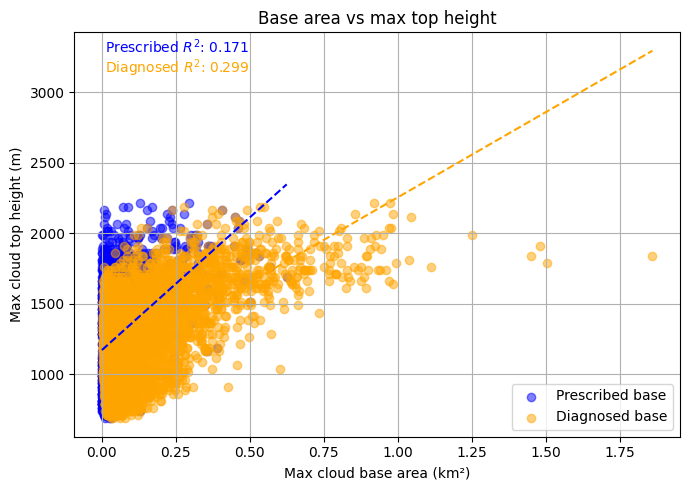

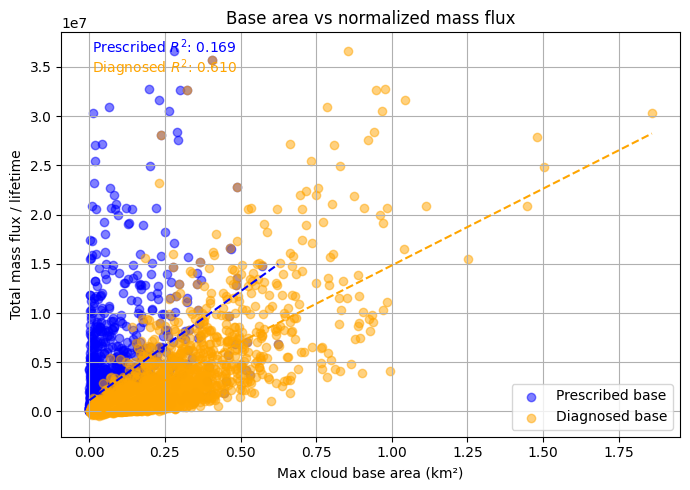

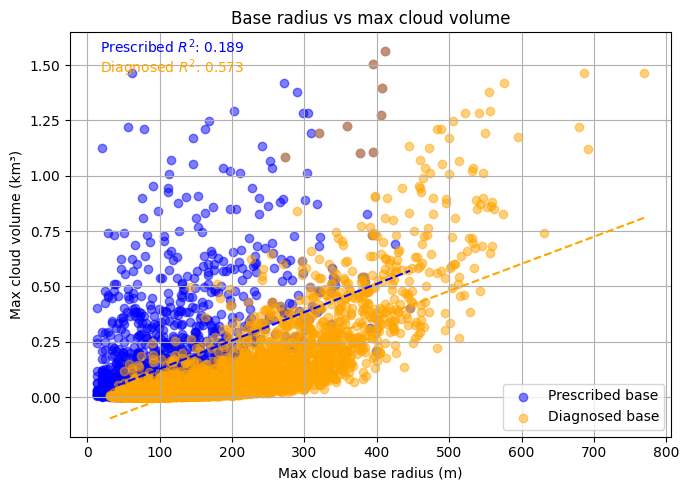

In [5]:
from scipy import stats

def extract_base_radii(raw, df_tracks):
    """
    Extract max prescribed and diagnosed base radii and top height for each track.
    Handles missing or malformed arrays gracefully.
    """
    # Defensive extraction
    prescribed = raw.get('base_radius_prescribed', None)
    diagnosed = raw.get('base_radius_diagnosed', None)
    top_height = raw.get('max_height', None)

    # Ensure arrays are present and have correct shape
    def safe_extract(arr, idx):
        if arr is None or not hasattr(arr, 'shape') or len(arr.shape) != 2:
            # Problem: array missing or not 2D
            # Risk: downstream IndexError, all NaN output
            # Fix: Return NaNs for all tracks
            return np.full(len(idx), np.nan)
        # Defensive: bounds check
        if arr.shape[0] < np.max(idx) + 1:
            # Problem: array too short for track indices
            # Risk: IndexError, incomplete extraction
            # Fix: Return NaNs for all tracks
            return np.full(len(idx), np.nan)
        # Extract max over time for each track
        return np.nanmax(arr[idx, :], axis=1)

    idx = df_tracks.track_index.values
    max_prescribed = safe_extract(prescribed, idx)
    max_diagnosed = safe_extract(diagnosed, idx)
    max_top_height = safe_extract(top_height, idx)
    return max_prescribed, max_diagnosed, max_top_height

max_prescribed, max_diagnosed, max_top_height = extract_base_radii(raw, df_tracks)

# Compute areas
area_prescribed = np.pi * max_prescribed**2 / 1e6  # convert to square km
area_diagnosed = np.pi * max_diagnosed**2 / 1e6

# Helper function to perform linear regression and add fit line
def add_linear_fit(x, y, ax, label, color):
    # Remove NaN values
    mask = ~np.isnan(x) & ~np.isnan(y)
    x_clean = x[mask]
    y_clean = y[mask]
    
    if len(x_clean) > 1:  # Need at least 2 points for regression
        # Calculate linear regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(x_clean, y_clean)
        r_squared = r_value**2
        
        # Add regression line to plot
        x_line = np.array([min(x_clean), max(x_clean)])
        y_line = slope * x_line + intercept
        ax.plot(x_line, y_line, color=color, linestyle='--')
        
        # Add R-squared text
        ax.text(0.05, 0.95 - 0.05 * ('Diagnosed' in label), 
                f"{label} $R^2$: {r_squared:.3f}", 
                transform=ax.transAxes, color=color)
    else:
        print(f"Warning: Not enough valid points for {label} linear fit")

# Relationship 1: base area vs max cloud top height
fig1, ax1 = plt.subplots(figsize=(7,5))
ax1.scatter(area_prescribed, max_top_height, alpha=0.5, label='Prescribed base', color='blue')
ax1.scatter(area_diagnosed, max_top_height, alpha=0.5, label='Diagnosed base', color='orange')

# Add linear fits
add_linear_fit(area_prescribed, max_top_height, ax1, 'Prescribed', 'blue')
add_linear_fit(area_diagnosed, max_top_height, ax1, 'Diagnosed', 'orange')

ax1.set_xlabel("Max cloud base area (km²)")
ax1.set_ylabel("Max cloud top height (m)")
ax1.set_title("Base area vs max top height")
ax1.legend(loc='lower right')
ax1.grid(True)
plt.tight_layout()

# Relationship 2: base area vs total mass flux (normalized by lifespan)
norm_mass_flux = df_tracks.mass_flux_metric / df_tracks.lifetime
fig2, ax2 = plt.subplots(figsize=(7,5))
ax2.scatter(area_prescribed, norm_mass_flux, alpha=0.5, label='Prescribed base', color='blue')
ax2.scatter(area_diagnosed, norm_mass_flux, alpha=0.5, label='Diagnosed base', color='orange')

# Add linear fits
add_linear_fit(area_prescribed, norm_mass_flux, ax2, 'Prescribed', 'blue')
add_linear_fit(area_diagnosed, norm_mass_flux, ax2, 'Diagnosed', 'orange')

ax2.set_xlabel("Max cloud base area (km²)")
ax2.set_ylabel("Total mass flux / lifetime")
ax2.set_title("Base area vs normalized mass flux")
ax2.legend(loc='lower right')
ax2.grid(True)
plt.tight_layout()

# Relationship 3: base radius vs max size in cubic kilometers
fig3, ax3 = plt.subplots(figsize=(7,5))

# Calculate the average voxel volume
# Note: You mentioned each voxel is 25*25*25 m³, but the code actually infers
# variable heights per level, so we'll calculate an average
mean_voxel_volume = np.mean(voxel_vol)  # in cubic meters

# Convert max size from points to cubic kilometers
max_size_km3 = df_tracks.max_size_points * mean_voxel_volume / 1e9

# Create scatter plot with converted units
ax3.scatter(max_prescribed, max_size_km3, alpha=0.5, label='Prescribed base', color='blue')
ax3.scatter(max_diagnosed, max_size_km3, alpha=0.5, label='Diagnosed base', color='orange')

# Add linear fits
add_linear_fit(max_prescribed, max_size_km3, ax3, 'Prescribed', 'blue')
add_linear_fit(max_diagnosed, max_size_km3, ax3, 'Diagnosed', 'orange')

ax3.set_xlabel("Max cloud base radius (m)")
ax3.set_ylabel("Max cloud volume (km³)")
ax3.set_title("Base radius vs max cloud volume")
ax3.legend(loc='lower right')
ax3.grid(True)
plt.tight_layout()

plt.show()

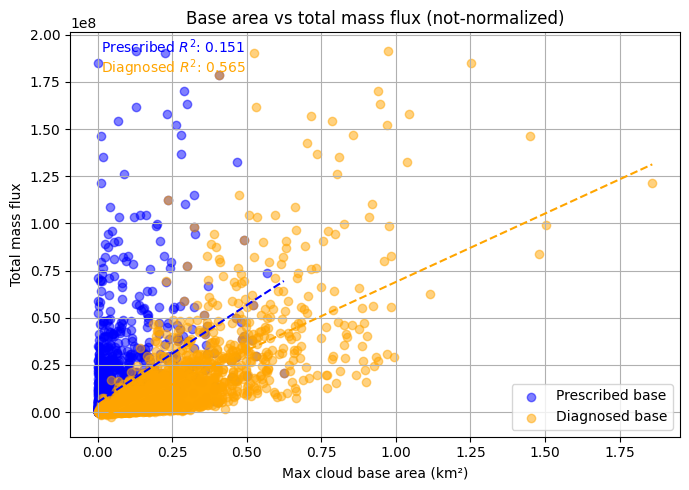

In [6]:
# Relationship 2a: base area vs total mass flux (unnormalized)
fig2a, ax2a = plt.subplots(figsize=(7,5))
ax2a.scatter(area_prescribed, df_tracks.mass_flux_metric, alpha=0.5, label='Prescribed base', color='blue')
ax2a.scatter(area_diagnosed, df_tracks.mass_flux_metric, alpha=0.5, label='Diagnosed base', color='orange')

# Add linear fits
add_linear_fit(area_prescribed, df_tracks.mass_flux_metric, ax2a, 'Prescribed', 'blue')
add_linear_fit(area_diagnosed, df_tracks.mass_flux_metric, ax2a, 'Diagnosed', 'orange')

ax2a.set_xlabel("Max cloud base area (km²)")
ax2a.set_ylabel("Total mass flux")
ax2a.set_title("Base area vs total mass flux (not-normalized)")
ax2a.legend(loc='lower right')
ax2a.grid(True)
plt.tight_layout()

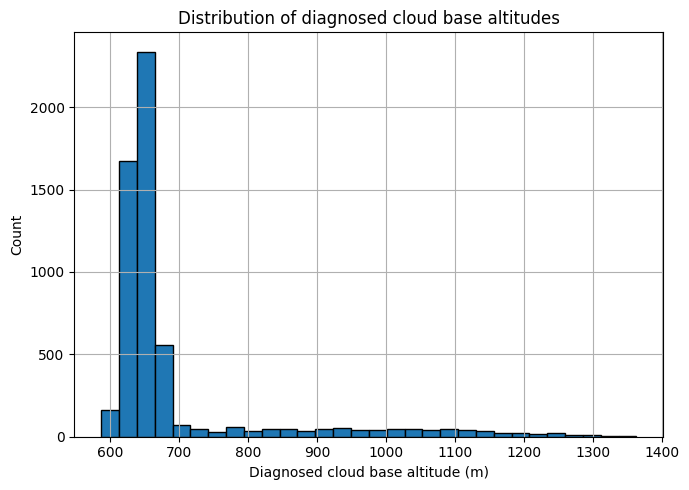

In [7]:
base_altitude = np.ma.filled(raw.get('cloud_base_height', None), np.nan)
idx = df_tracks.track_index.values
min_base_altitude = np.nanmin(base_altitude[idx, :], axis=1)
plt.figure(figsize=(7,5))
plt.hist(min_base_altitude[~np.isnan(min_base_altitude)], bins=30, edgecolor='black')
plt.xlabel("Diagnosed cloud base altitude (m)")
plt.ylabel("Count")
plt.title("Distribution of diagnosed cloud base altitudes")
plt.grid(True)
plt.tight_layout()
plt.show()

# Detachment of clouds base, or not?

/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_14467/1782146688.py:32: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  (tracks_df.max_size_points >= min_cloud_size) &


Filtered from 5639 to 2053 clouds (min size: 10, min lifetime: 5, only valid tracks)


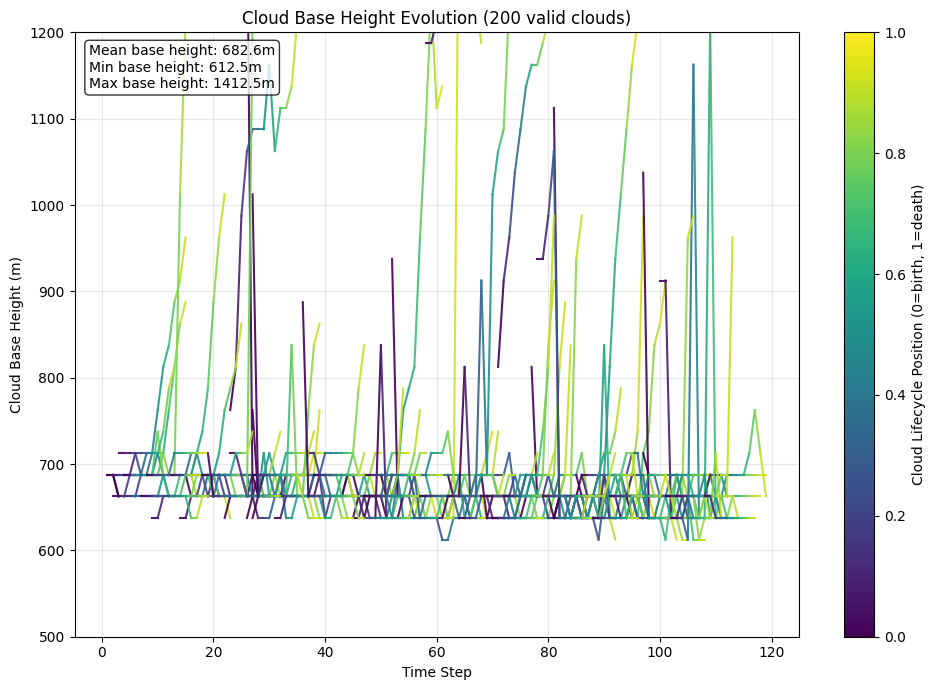

In [8]:
# Function to plot cloud base height evolution with improved filtering
def plot_cloud_base_height_evolution(raw_data, tracks_df, 
                                    min_cloud_size=100,       # Min size in points
                                    min_lifetime=3,           # Min lifetime in timesteps
                                    max_clouds=None,          # Max clouds to plot
                                    alpha=0.3,                # Line transparency
                                    height_range=None):       # Optional y-axis range
    """
    Plot the evolution of cloud base height over time for each valid cloud track.
    
    Parameters:
    - raw_data: Dictionary containing the cloud_base_height array
    - tracks_df: DataFrame with filtered valid tracks
    - min_cloud_size: Minimum max size (in points) for clouds to include
    - min_lifetime: Minimum lifetime (in timesteps) for clouds to include
    - max_clouds: Maximum number of clouds to plot (None = all)
    - alpha: Transparency for individual cloud lines
    - height_range: Optional tuple of (min_height, max_height) to constrain y-axis
    """
    # Extract cloud base height data
    base_height = np.ma.filled(raw_data.get('cloud_base_height', None), np.nan)
    
    if base_height is None:
        print("Cloud base height data not available")
        return
    
    # Get valid tracks mask from raw data to ensure we only use non-tainted tracks
    valid_tracks_mask = raw_data.get('valid_track', np.ones(len(tracks_df))) == 1
    
    # Apply size, lifetime, and valid track filters
    filtered_df = tracks_df[
        (tracks_df.max_size_points >= min_cloud_size) & 
        (tracks_df.lifetime >= min_lifetime) &
        # Only include track indices that are marked as valid
        [valid_tracks_mask[idx] for idx in tracks_df.track_index.values]
    ].copy()
    
    print(f"Filtered from {len(tracks_df)} to {len(filtered_df)} clouds "
          f"(min size: {min_cloud_size}, min lifetime: {min_lifetime}, only valid tracks)")
    
    # Create figure and axes explicitly
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Get track indices from filtered dataframe
    track_indices = filtered_df.track_index.values
    
    # Limit number of plotted clouds if requested
    if max_clouds is not None and max_clouds < len(track_indices):
        # Use consistently longest-lived clouds for better visualization
        idx = np.argsort(-filtered_df.lifetime.values)[:max_clouds]
        track_indices = track_indices[idx]
    
    # Color map for cloud lifecycle stage
    cmap = plt.cm.viridis
    
    # Counter for plotted tracks
    plotted = 0
    
    # Plot each cloud's base height evolution
    for i, idx in enumerate(track_indices):
        # Extract time series for this cloud
        heights = base_height[idx, :]
        
        # Find valid timesteps (where height is not NaN)
        valid_mask = ~np.isnan(heights)
        if not np.any(valid_mask):
            continue
        
        # Get timesteps (relative to cloud's own lifecycle)
        timesteps = np.arange(len(heights))[valid_mask]
        cloud_heights = heights[valid_mask]
        
        # Normalize lifecycle position for coloring (0=birth, 1=death)
        positions = np.linspace(0, 1, len(timesteps))
        
        # Plot with color based on lifecycle position
        for j in range(len(timesteps)-1):
            ax.plot(timesteps[j:j+2], cloud_heights[j:j+2], 
                   color=cmap(positions[j]), linewidth=1.5, alpha=alpha)
        
        plotted += 1
    
    # Add a colorbar to show lifecycle stage
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, 1))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Cloud Lifecycle Position (0=birth, 1=death)')
    
    # Add annotations
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Cloud Base Height (m)')
    ax.set_title(f'Cloud Base Height Evolution ({plotted} valid clouds)')
    
    # Set height range if provided
    if height_range is not None:
        ax.set_ylim(height_range)
    
    # Add a horizontal line at the model cloud base level (if available)
    cloud_base_altitude = raw_data.get('config_cloud_base_altitude', None)
    if cloud_base_altitude is not None:
        ax.axhline(y=cloud_base_altitude, color='r', linestyle='--', alpha=0.7, 
                  label=f'Model Cloud Base: {cloud_base_altitude}m')
        ax.legend()
    
    # Calculate statistics for the plotted clouds
    if plotted > 0:
        mean_base_height = np.nanmean([np.nanmean(base_height[idx, :]) for idx in track_indices[:plotted]])
        min_base_height = np.nanmin([np.nanmin(base_height[idx, :][~np.isnan(base_height[idx, :])]) 
                                   for idx in track_indices[:plotted]])
        max_base_height = np.nanmax([np.nanmax(base_height[idx, :]) for idx in track_indices[:plotted]])
        
        # Add statistics text to the plot
        stats_text = (f"Mean base height: {mean_base_height:.1f}m\n"
                      f"Min base height: {min_base_height:.1f}m\n"
                      f"Max base height: {max_base_height:.1f}m")
        
        # Position text in upper left corner
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    return fig, ax

# Example usage with different filtering settings
fig1, ax1 = plot_cloud_base_height_evolution(
    raw, df_tracks, 
    min_cloud_size=10,     # Only clouds with significant size
    min_lifetime=5,         # Clouds that exist for at least 5 timesteps
    max_clouds=200,          # Limit number of clouds for clarity
    alpha=0.9,              # Moderate transparency
    height_range=(500, 1200) # Focus on typical cloud base region
)
plt.show()

### Pull all lifespans to start at time 0.

/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_14467/2067363155.py:33: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  (tracks_df.max_size_points >= min_cloud_size) &


Filtered from 5639 to 2053 clouds (min size: 10, min lifetime: 5, only valid tracks)


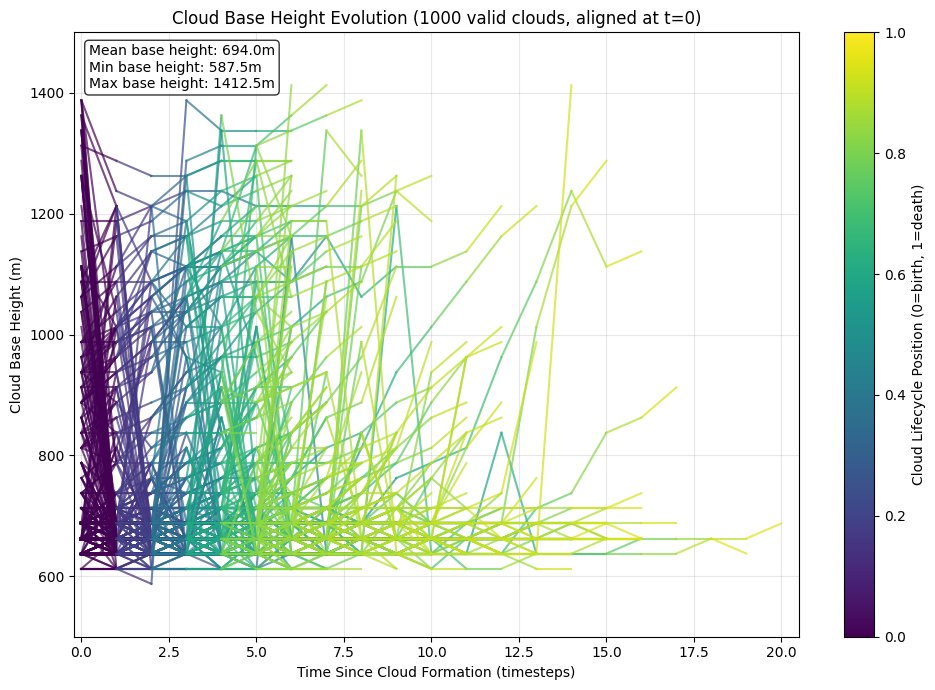

In [9]:
# Function to plot cloud base height evolution with all timelines aligned to t=0
def plot_cloud_base_height_evolution(raw_data, tracks_df, 
                                    min_cloud_size=100,       # Min size in points
                                    min_lifetime=3,           # Min lifetime in timesteps
                                    max_clouds=None,          # Max clouds to plot
                                    alpha=0.3,                # Line transparency
                                    height_range=None):       # Optional y-axis range
    """
    Plot the evolution of cloud base height over time for each valid cloud track,
    with all timelines aligned to start at t=0 for easier comparison.
    
    Parameters:
    - raw_data: Dictionary containing the cloud_base_height array
    - tracks_df: DataFrame with filtered valid tracks
    - min_cloud_size: Minimum max size (in points) for clouds to include
    - min_lifetime: Minimum lifetime (in timesteps) for clouds to include
    - max_clouds: Maximum number of clouds to plot (None = all)
    - alpha: Transparency for individual cloud lines
    - height_range: Optional tuple of (min_height, max_height) to constrain y-axis
    """
    # Extract cloud base height data
    base_height = np.ma.filled(raw_data.get('cloud_base_height', None), np.nan)
    
    if base_height is None:
        print("Cloud base height data not available")
        return
    
    # Get valid tracks mask from raw data to ensure we only use non-tainted tracks
    valid_tracks_mask = raw_data.get('valid_track', np.ones(len(tracks_df))) == 1
    
    # Apply size, lifetime, and valid track filters
    filtered_df = tracks_df[
        (tracks_df.max_size_points >= min_cloud_size) & 
        (tracks_df.lifetime >= min_lifetime) &
        # Only include track indices that are marked as valid
        [valid_tracks_mask[idx] for idx in tracks_df.track_index.values]
    ].copy()
    
    print(f"Filtered from {len(tracks_df)} to {len(filtered_df)} clouds "
          f"(min size: {min_cloud_size}, min lifetime: {min_lifetime}, only valid tracks)")
    
    # Create figure and axes explicitly
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Get track indices from filtered dataframe
    track_indices = filtered_df.track_index.values
    
    # Limit number of plotted clouds if requested
    if max_clouds is not None and max_clouds < len(track_indices):
        # Use consistently longest-lived clouds for better visualization
        idx = np.argsort(-filtered_df.lifetime.values)[:max_clouds]
        track_indices = track_indices[idx]
    
    # Color map for cloud lifecycle stage
    cmap = plt.cm.viridis
    
    # Counter for plotted tracks and tracking maximum lifetime
    plotted = 0
    max_lifetime = 0
    
    # Plot each cloud's base height evolution
    for i, idx in enumerate(track_indices):
        # Extract time series for this cloud
        heights = base_height[idx, :]
        
        # Find valid timesteps (where height is not NaN)
        valid_mask = ~np.isnan(heights)
        if not np.any(valid_mask):
            continue
        
        # Get original timesteps where cloud data exists
        original_timesteps = np.arange(len(heights))[valid_mask]
        cloud_heights = heights[valid_mask]
        
        # Normalize the timesteps to start at 0 for this cloud
        relative_timesteps = original_timesteps - original_timesteps[0]
        
        # Track maximum lifetime for x-axis scale
        max_lifetime = max(max_lifetime, relative_timesteps[-1])
        
        # Normalize lifecycle position for coloring (0=birth, 1=death)
        positions = np.linspace(0, 1, len(relative_timesteps))
        
        # Plot with color based on lifecycle position
        for j in range(len(relative_timesteps)-1):
            ax.plot(relative_timesteps[j:j+2], cloud_heights[j:j+2], 
                   color=cmap(positions[j]), linewidth=1.5, alpha=alpha)
        
        plotted += 1
    
    # Add a colorbar to show lifecycle stage
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, 1))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Cloud Lifecycle Position (0=birth, 1=death)')
    
    # Add annotations
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('Time Since Cloud Formation (timesteps)')
    ax.set_ylabel('Cloud Base Height (m)')
    ax.set_title(f'Cloud Base Height Evolution ({plotted} valid clouds, aligned at t=0)')
    
    # Set height range if provided
    if height_range is not None:
        ax.set_ylim(height_range)
    
    # Add a horizontal line at the model cloud base level (if available)
    cloud_base_altitude = raw_data.get('config_cloud_base_altitude', None)
    if cloud_base_altitude is not None:
        ax.axhline(y=cloud_base_altitude, color='r', linestyle='--', alpha=0.7, 
                  label=f'Model Cloud Base: {cloud_base_altitude}m')
        ax.legend()
    
    # Calculate statistics for the plotted clouds
    if plotted > 0:
        mean_base_height = np.nanmean([np.nanmean(base_height[idx, :][~np.isnan(base_height[idx, :])]) 
                                     for idx in track_indices[:plotted]])
        min_base_height = np.nanmin([np.nanmin(base_height[idx, :][~np.isnan(base_height[idx, :])]) 
                                   for idx in track_indices[:plotted]])
        max_base_height = np.nanmax([np.nanmax(base_height[idx, :][~np.isnan(base_height[idx, :])]) 
                                   for idx in track_indices[:plotted]])
        
        # Add statistics text to the plot
        stats_text = (f"Mean base height: {mean_base_height:.1f}m\n"
                      f"Min base height: {min_base_height:.1f}m\n"
                      f"Max base height: {max_base_height:.1f}m")
        
        # Position text in upper left corner
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Ensure x-axis starts at 0 and add a bit of padding
    ax.set_xlim(-0.2, max_lifetime + 0.5)
    
    plt.tight_layout()
    return fig, ax

# Example usage with different filtering settings
fig1, ax1 = plot_cloud_base_height_evolution(
    raw, df_tracks, 
    min_cloud_size=10,      # Only clouds with significant size
    min_lifetime=5,          # Clouds that exist for at least 5 timesteps
    max_clouds=1000,           # Limit number of clouds for clarity
    alpha=0.7,               # Moderate transparency
    height_range=(500, 1500) # Focus on typical cloud base region
)
plt.show()

Just to see how it looks, removing all cloudbases that start above 700m. 

/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_14467/1562447384.py:36: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  (tracks_df.max_size_points >= min_cloud_size) &


Filtered from 5639 to 2053 clouds (min size: 10, min lifetime: 5, only valid tracks)
Filtered out 128 clouds with initial height > 700m
Plotting 872 clouds with initial height ≤ 700m


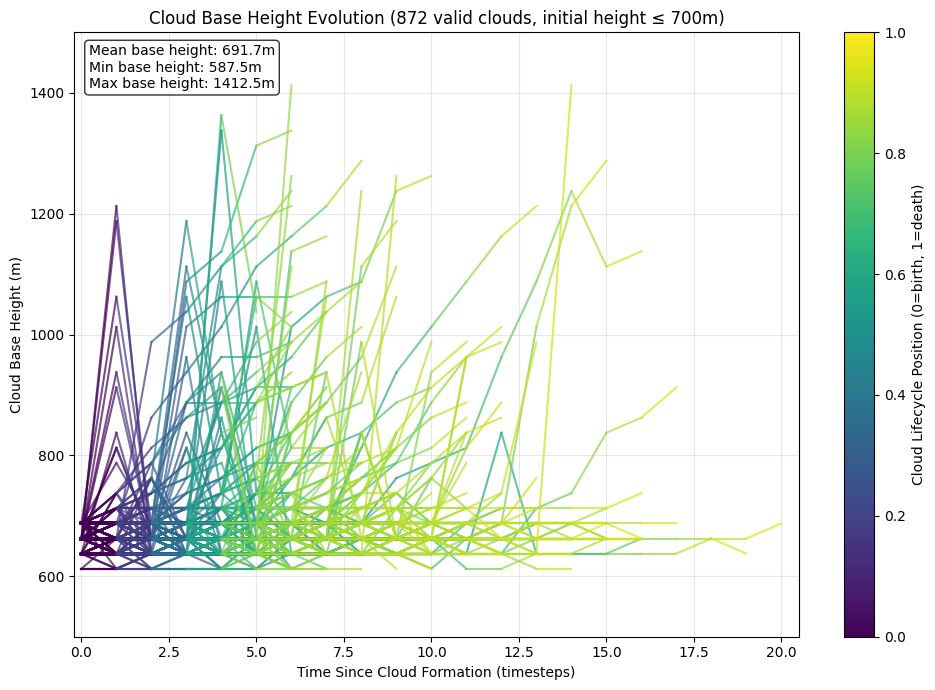

In [10]:
# Function to plot cloud base height evolution with all timelines aligned to t=0
# and filtering clouds that start above max_initial_height
def plot_cloud_base_height_evolution(raw_data, tracks_df, 
                                    min_cloud_size=100,       # Min size in points
                                    min_lifetime=3,           # Min lifetime in timesteps
                                    max_clouds=None,          # Max clouds to plot
                                    alpha=0.3,                # Line transparency
                                    height_range=None,        # Optional y-axis range
                                    max_initial_height=700):  # Max allowed initial cloud base height
    """
    Plot the evolution of cloud base height over time for each valid cloud track,
    with all timelines aligned to start at t=0 for easier comparison.
    
    Parameters:
    - raw_data: Dictionary containing the cloud_base_height array
    - tracks_df: DataFrame with filtered valid tracks
    - min_cloud_size: Minimum max size (in points) for clouds to include
    - min_lifetime: Minimum lifetime (in timesteps) for clouds to include
    - max_clouds: Maximum number of clouds to plot (None = all)
    - alpha: Transparency for individual cloud lines
    - height_range: Optional tuple of (min_height, max_height) to constrain y-axis
    - max_initial_height: Maximum allowed initial cloud base height (m)
    """
    # Extract cloud base height data
    base_height = np.ma.filled(raw_data.get('cloud_base_height', None), np.nan)
    
    if base_height is None:
        print("Cloud base height data not available")
        return
    
    # Get valid tracks mask from raw data to ensure we only use non-tainted tracks
    valid_tracks_mask = raw_data.get('valid_track', np.ones(len(tracks_df))) == 1
    
    # Apply size, lifetime, and valid track filters
    filtered_df = tracks_df[
        (tracks_df.max_size_points >= min_cloud_size) & 
        (tracks_df.lifetime >= min_lifetime) &
        # Only include track indices that are marked as valid
        [valid_tracks_mask[idx] for idx in tracks_df.track_index.values]
    ].copy()
    
    print(f"Filtered from {len(tracks_df)} to {len(filtered_df)} clouds "
          f"(min size: {min_cloud_size}, min lifetime: {min_lifetime}, only valid tracks)")
    
    # Create figure and axes explicitly
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Get track indices from filtered dataframe
    track_indices = filtered_df.track_index.values
    
    # Limit number of plotted clouds if requested
    if max_clouds is not None and max_clouds < len(track_indices):
        # Use consistently longest-lived clouds for better visualization
        idx = np.argsort(-filtered_df.lifetime.values)[:max_clouds]
        track_indices = track_indices[idx]
    
    # Color map for cloud lifecycle stage
    cmap = plt.cm.viridis
    
    # Counter for plotted tracks and tracking maximum lifetime
    plotted = 0
    filtered_by_height = 0
    max_lifetime = 0
    
    # Plot each cloud's base height evolution
    for i, idx in enumerate(track_indices):
        # Extract time series for this cloud
        heights = base_height[idx, :]
        
        # Find valid timesteps (where height is not NaN)
        valid_mask = ~np.isnan(heights)
        if not np.any(valid_mask):
            continue
        
        # Get original timesteps where cloud data exists
        original_timesteps = np.arange(len(heights))[valid_mask]
        cloud_heights = heights[valid_mask]
        
        # Filter clouds that start above max_initial_height
        if cloud_heights[0] > max_initial_height:
            filtered_by_height += 1
            continue
            
        # Normalize the timesteps to start at 0 for this cloud
        relative_timesteps = original_timesteps - original_timesteps[0]
        
        # Track maximum lifetime for x-axis scale
        max_lifetime = max(max_lifetime, relative_timesteps[-1])
        
        # Normalize lifecycle position for coloring (0=birth, 1=death)
        positions = np.linspace(0, 1, len(relative_timesteps))
        
        # Plot with color based on lifecycle position
        for j in range(len(relative_timesteps)-1):
            ax.plot(relative_timesteps[j:j+2], cloud_heights[j:j+2], 
                   color=cmap(positions[j]), linewidth=1.5, alpha=alpha)
        
        plotted += 1
    
    # Print height filtering statistics
    print(f"Filtered out {filtered_by_height} clouds with initial height > {max_initial_height}m")
    print(f"Plotting {plotted} clouds with initial height ≤ {max_initial_height}m")
    
    # Add a colorbar to show lifecycle stage
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, 1))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Cloud Lifecycle Position (0=birth, 1=death)')
    
    # Add annotations
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('Time Since Cloud Formation (timesteps)')
    ax.set_ylabel('Cloud Base Height (m)')
    ax.set_title(f'Cloud Base Height Evolution ({plotted} valid clouds, initial height ≤ {max_initial_height}m)')
    
    # Set height range if provided
    if height_range is not None:
        ax.set_ylim(height_range)
    
    # Add a horizontal line at the model cloud base level (if available)
    cloud_base_altitude = raw_data.get('config_cloud_base_altitude', None)
    if cloud_base_altitude is not None:
        ax.axhline(y=cloud_base_altitude, color='r', linestyle='--', alpha=0.7, 
                  label=f'Model Cloud Base: {cloud_base_altitude}m')
        ax.legend()
    
    # Calculate statistics for the plotted clouds
    if plotted > 0:
        mean_base_height = np.nanmean([np.nanmean(base_height[idx, :][~np.isnan(base_height[idx, :])]) 
                                     for idx in track_indices[:plotted]])
        min_base_height = np.nanmin([np.nanmin(base_height[idx, :][~np.isnan(base_height[idx, :])]) 
                                   for idx in track_indices[:plotted]])
        max_base_height = np.nanmax([np.nanmax(base_height[idx, :][~np.isnan(base_height[idx, :])]) 
                                   for idx in track_indices[:plotted]])
        
        # Add statistics text to the plot
        stats_text = (f"Mean base height: {mean_base_height:.1f}m\n"
                      f"Min base height: {min_base_height:.1f}m\n"
                      f"Max base height: {max_base_height:.1f}m")
        
        # Position text in upper left corner
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Ensure x-axis starts at 0 and add a bit of padding
    ax.set_xlim(-0.2, max_lifetime + 0.5)
    
    plt.tight_layout()
    return fig, ax

# Example usage with different filtering settings
fig1, ax1 = plot_cloud_base_height_evolution(
    raw, df_tracks, 
    min_cloud_size=10,       # Only clouds with significant size
    min_lifetime=5,          # Clouds that exist for at least 5 timesteps
    max_clouds=1000,         # Limit number of clouds for clarity
    alpha=0.7,               # Moderate transparency
    height_range=(500, 1500),# Focus on typical cloud base region
    max_initial_height=700   # Only show clouds that start below 700m
)
plt.show()

# Cloud base detachment fraction of clouds

In [11]:
def analyze_cloud_base_detachment_with_lifespan_plots(raw_data, tracks_df, 
                                                    detachment_threshold=50,
                                                    min_lifetime_steps=3,
                                                    min_size_points=10):
    """
    Analyze cloud base detachment with enhanced lifespan visualizations.
    
    Parameters:
    - raw_data: Dictionary with cloud tracking data
    - tracks_df: DataFrame with filtered valid tracks
    - detachment_threshold: Height (m) increase to consider "detached" for diagnosed
    - min_lifetime_steps: Minimum cloud lifetime
    - min_size_points: Minimum cloud size
    
    Returns:
    - Dictionary with detachment statistics and creates separate visualizations
    """
    # Get required data
    diag_base_height = np.ma.filled(raw_data.get('cloud_base_height', None), np.nan)
    pres_base_radius = np.ma.filled(raw_data.get('base_radius_prescribed', None), np.nan)
    size = np.ma.filled(raw_data.get('size', None), np.nan)
    valid_track_mask = raw_data.get('valid_track', np.ones(len(tracks_df))) == 1
    
    # Get the age data - this is a 2D array (track, time)
    age = np.ma.filled(raw_data.get('age', None), np.nan)
    if age is None:
        print("Warning: Age data not available. Using lifetime from size instead.")
        use_age_data = False
    else:
        use_age_data = True
    
    # Filter for valid tracks
    track_indices = []
    for i, row in tracks_df.iterrows():
        idx = row.track_index
        if valid_track_mask[idx] and row.lifetime >= min_lifetime_steps and row.max_size_points >= min_size_points:
            track_indices.append(idx)
    
    # Initialize collections for results
    # Diagnosed method
    diag_tracks_analyzed = []
    diag_detached_tracks = []
    diag_attached_tracks = []
    diag_detachment_timestep = []  # Actual timestep when detachment occurs
    diag_detachment_normalized = []  # Normalized position (0-1)
    diag_lifespans_detached = []
    diag_lifespans_attached = []
    diag_ages_at_detachment = []  # Age at detachment time
    diag_ages_at_birth = []  # Initial age of clouds that eventually detach
    diag_max_ages_detached = []  # Maximum age reached for detached clouds
    diag_max_ages_attached = []  # Maximum age reached for attached clouds
    
    # Prescribed method
    pres_tracks_analyzed = []
    pres_detached_tracks = []
    pres_attached_tracks = []
    pres_detachment_timestep = []
    pres_detachment_normalized = []
    pres_lifespans_detached = []
    pres_lifespans_attached = []
    pres_ages_at_detachment = []  # Age at detachment time
    pres_ages_at_birth = []  # Initial age of clouds that eventually detach
    pres_max_ages_detached = []  # Maximum age reached for detached clouds
    pres_max_ages_attached = []  # Maximum age reached for attached clouds
    
    # Analyze each track
    for idx in track_indices:
        # Extract data
        diag_heights = diag_base_height[idx, :]
        pres_radii = pres_base_radius[idx, :]
        track_size = size[idx, :]
        
        # Extract cloud age at each timestep if available
        if use_age_data:
            track_ages = age[idx, :]
        
        # Find valid timesteps (where size is not NaN)
        valid_timesteps = ~np.isnan(track_size)
        valid_timesteps_indices = np.where(valid_timesteps)[0]
        
        if len(valid_timesteps_indices) < min_lifetime_steps:
            continue
            
        first_valid_idx = valid_timesteps_indices[0]
        last_valid_idx = valid_timesteps_indices[-1]
        total_lifespan = np.sum(valid_timesteps)
        
        # ------------- Diagnosed Base Analysis -------------
        # Filter out NaN values for diagnosed method
        diag_valid_mask = ~np.isnan(diag_heights)
        if np.sum(diag_valid_mask) >= min_lifetime_steps:
            # Track is valid for diagnosed analysis
            diag_tracks_analyzed.append(idx)
            
            # Extract height data for valid timesteps
            track_timesteps = np.arange(len(diag_heights))[diag_valid_mask]
            diag_track_heights = diag_heights[diag_valid_mask]
            
            # Use the initial height as reference
            initial_height_diag = diag_track_heights[0]
            
            # Find first point of detachment (if any)
            detached_indices_diag = np.where(diag_track_heights > (initial_height_diag + detachment_threshold))[0]
            
            if len(detached_indices_diag) > 0:
                # Cloud detached at some point
                diag_detached_tracks.append(idx)
                
                # Record when detachment occurs
                first_detachment_idx_diag = detached_indices_diag[0]
                detachment_timestep = track_timesteps[first_detachment_idx_diag]
                diag_detachment_timestep.append(detachment_timestep)
                diag_detachment_normalized.append(first_detachment_idx_diag / len(track_timesteps))
                
                # Store lifespan
                diag_lifespans_detached.append(len(track_timesteps))
                
                # Store age information if available
                if use_age_data:
                    # Get ages at key points in cloud lifecycle
                    birth_age = track_ages[first_valid_idx]
                    detachment_age = track_ages[detachment_timestep]
                    max_age = np.nanmax(track_ages[valid_timesteps])
                    
                    diag_ages_at_birth.append(birth_age)
                    diag_ages_at_detachment.append(detachment_age)
                    diag_max_ages_detached.append(max_age)
            else:
                # Cloud stayed attached
                diag_attached_tracks.append(idx)
                diag_lifespans_attached.append(len(track_timesteps))
                
                # Store age information if available
                if use_age_data:
                    birth_age = track_ages[first_valid_idx]
                    max_age = np.nanmax(track_ages[valid_timesteps])
                    diag_max_ages_attached.append(max_age)
        
        # ------------- Prescribed Base Analysis -------------
        # Find where cloud has points at the prescribed base (not NaN)
        has_points_at_base = ~np.isnan(pres_radii)
        
        # Only consider clouds that have points at the base at some point
        if np.any(has_points_at_base) and has_points_at_base[first_valid_idx]:
            # Track is valid for prescribed analysis
            pres_tracks_analyzed.append(idx)
            
            # Check if the cloud loses contact with the base after initially having it
            detached = False
            detachment_timestep = None
            
            for t in range(first_valid_idx + 1, len(pres_radii)):
                if valid_timesteps[t] and not has_points_at_base[t]:
                    detached = True
                    detachment_timestep = t
                    # Record when detachment occurs
                    pres_detachment_timestep.append(t)
                    pres_detachment_normalized.append((t - first_valid_idx) / total_lifespan)
                    break
            
            if detached:
                pres_detached_tracks.append(idx)
                pres_lifespans_detached.append(total_lifespan)
                
                # Store age information if available
                if use_age_data and detachment_timestep is not None:
                    birth_age = track_ages[first_valid_idx]
                    detachment_age = track_ages[detachment_timestep]
                    max_age = np.nanmax(track_ages[valid_timesteps])
                    
                    pres_ages_at_birth.append(birth_age)
                    pres_ages_at_detachment.append(detachment_age)
                    pres_max_ages_detached.append(max_age)
            else:
                pres_attached_tracks.append(idx)
                pres_lifespans_attached.append(total_lifespan)
                
                # Store age information if available
                if use_age_data:
                    birth_age = track_ages[first_valid_idx]
                    max_age = np.nanmax(track_ages[valid_timesteps])
                    pres_max_ages_attached.append(max_age)
    
    # Calculate percentages
    diag_total = len(diag_tracks_analyzed)
    diag_detached_count = len(diag_detached_tracks)
    diag_detached_pct = (diag_detached_count / diag_total * 100) if diag_total > 0 else 0
    diag_attached_pct = 100 - diag_detached_pct
    
    pres_total = len(pres_tracks_analyzed)
    pres_detached_count = len(pres_detached_tracks)
    pres_detached_pct = (pres_detached_count / pres_total * 100) if pres_total > 0 else 0
    pres_attached_pct = 100 - pres_detached_pct
    
    # Create result dictionary
    results = {
        'diag_total': diag_total,
        'diag_detached': diag_detached_count,
        'diag_detached_pct': diag_detached_pct,
        'diag_attached_pct': diag_attached_pct,
        
        'pres_total': pres_total,
        'pres_detached': pres_detached_count,
        'pres_detached_pct': pres_detached_pct,
        'pres_attached_pct': pres_attached_pct,
        
        'diag_threshold_m': detachment_threshold,
        'min_lifetime_steps': min_lifetime_steps,
        'min_size_points': min_size_points,
        
        # Additional data for plots
        'diag_detachment_timestep': diag_detachment_timestep,
        'diag_detachment_normalized': diag_detachment_normalized,
        'diag_lifespans_detached': diag_lifespans_detached,
        'diag_lifespans_attached': diag_lifespans_attached,
        
        # Age information (with correct interpretation)
        'diag_ages_at_birth': diag_ages_at_birth,
        'diag_ages_at_detachment': diag_ages_at_detachment,
        'diag_max_ages_detached': diag_max_ages_detached,
        'diag_max_ages_attached': diag_max_ages_attached,
        
        'pres_detachment_timestep': pres_detachment_timestep,
        'pres_detachment_normalized': pres_detachment_normalized,
        'pres_lifespans_detached': pres_lifespans_detached,
        'pres_lifespans_attached': pres_lifespans_attached,
        
        # Age information (with correct interpretation)
        'pres_ages_at_birth': pres_ages_at_birth,
        'pres_ages_at_detachment': pres_ages_at_detachment,
        'pres_max_ages_detached': pres_max_ages_detached,
        'pres_max_ages_attached': pres_max_ages_attached,
        
        'use_age_data': use_age_data
    }
    
    # Create visualizations
    create_lifespan_visualizations(results)
    
    return results


def create_lifespan_visualizations(results):
    """
    Create detailed visualizations for cloud lifespan and detachment analysis.
    
    Parameters:
    - results: Dictionary with detachment analysis results
    """
    # Create a figure with 2x2 plots
    fig = plt.figure(figsize=(15, 10))
    
    # Helper function to ensure 1D array format
    def ensure_1d_array(data):
        if data is None or len(data) == 0:
            return np.array([])
        data_array = np.asarray(data)
        if data_array.ndim > 1:
            # If multidimensional, flatten to 1D
            return data_array.flatten()
        return data_array
    
    # 1. When do clouds detach? (Normalized 0-1 in cloud lifecycle)
    ax1 = plt.subplot2grid((2, 2), (0, 0))
    diag_detach_norm = ensure_1d_array(results['diag_detachment_normalized'])
    pres_detach_norm = ensure_1d_array(results['pres_detachment_normalized'])
    
    if len(diag_detach_norm) > 0 and len(pres_detach_norm) > 0:
        ax1.hist([diag_detach_norm, pres_detach_norm], 
                bins=10, range=(0, 1), 
                label=['Diagnosed', 'Prescribed'],
                alpha=0.7, color=['skyblue', 'salmon'])
        ax1.set_xlabel('Cloud Lifecycle Position (0=birth, 1=death)')
        ax1.set_ylabel('Count')
        ax1.set_title('When Do Clouds Detach Within Their Lifecycle?')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Add statistics
        diag_avg = np.mean(diag_detach_norm)
        pres_avg = np.mean(pres_detach_norm)
        stats_text = f"Average detachment time:\nDiagnosed: {diag_avg:.2f}\nPrescribed: {pres_avg:.2f}"
        ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    else:
        ax1.text(0.5, 0.5, "Insufficient detachment data", 
                ha='center', va='center', transform=ax1.transAxes)
    
    # 2. When do clouds detach? (Steps since cloud birth)
    ax2 = plt.subplot2grid((2, 2), (0, 1))
    diag_detach_steps = ensure_1d_array(results['diag_detachment_timestep'])
    pres_detach_steps = ensure_1d_array(results['pres_detachment_timestep'])
    
    if len(diag_detach_steps) > 0 and len(pres_detach_steps) > 0:
        all_steps = np.concatenate([diag_detach_steps, pres_detach_steps])
        max_step = max(all_steps) if len(all_steps) > 0 else 20
        
        ax2.hist([diag_detach_steps, pres_detach_steps], 
                bins=min(20, max(10, int(max_step//2))), 
                range=(0, max_step + 1),
                label=['Diagnosed', 'Prescribed'],
                alpha=0.7, color=['skyblue', 'salmon'])
        ax2.set_xlabel('Steps Since Cloud Formation')
        ax2.set_ylabel('Count')
        ax2.set_title('When Do Clouds Detach? (Steps in Cloud Lifecycle)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Add statistics
        diag_avg = np.mean(diag_detach_steps)
        pres_avg = np.mean(pres_detach_steps)
        stats_text = f"Average steps until detachment:\nDiagnosed: {diag_avg:.1f}\nPrescribed: {pres_avg:.1f}"
        ax2.text(0.02, 0.98, stats_text, transform=ax2.transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    else:
        ax2.text(0.5, 0.5, "Insufficient detachment data", 
                ha='center', va='center', transform=ax2.transAxes)
    
    # Age analysis from NetCDF (if available)
    if results['use_age_data']:
        # 3. Maximum age comparison: Detached vs Attached (Diagnosed)
        ax3 = plt.subplot2grid((2, 2), (1, 0))
        diag_max_ages_attached = ensure_1d_array(results['diag_max_ages_attached'])
        diag_max_ages_detached = ensure_1d_array(results['diag_max_ages_detached'])
        
        if len(diag_max_ages_attached) > 0 and len(diag_max_ages_detached) > 0:
            boxdata = [diag_max_ages_attached, diag_max_ages_detached]
            ax3.boxplot(boxdata, labels=['Attached', 'Detached'])
            
            # Add individual points for better visualization
            for i, data in enumerate([diag_max_ages_attached, diag_max_ages_detached]):
                if len(data) > 0:
                    # Add jitter to x position
                    x = np.random.normal(i+1, 0.04, size=len(data))
                    ax3.scatter(x, data, alpha=0.4, color='blue', edgecolor='black')
            
            # Add statistics        
            attached_avg = np.nanmean(diag_max_ages_attached)
            detached_avg = np.nanmean(diag_max_ages_detached)
            stats_text = (f"Average max age:\nAttached: {attached_avg:.1f}\n"
                         f"Detached: {detached_avg:.1f}\n"
                         f"Attached count: {len(diag_max_ages_attached)}\n"
                         f"Detached count: {len(diag_max_ages_detached)}")
            ax3.text(0.02, 0.98, stats_text, transform=ax3.transAxes,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
                    
            ax3.set_ylabel('Maximum Age (timesteps)')
            ax3.set_title('Diagnosed Method: Cloud Age Comparison')
            ax3.grid(True, alpha=0.3)
        else:
            ax3.text(0.5, 0.5, "Insufficient age data", 
                    ha='center', va='center', transform=ax3.transAxes)
        
        # 4. Age at detachment vs initial age (Prescribed method)
        ax4 = plt.subplot2grid((2, 2), (1, 1))
        pres_max_ages_attached = ensure_1d_array(results['pres_max_ages_attached'])
        pres_max_ages_detached = ensure_1d_array(results['pres_max_ages_detached'])
        
        if len(pres_max_ages_attached) > 0 and len(pres_max_ages_detached) > 0:
            boxdata = [pres_max_ages_attached, pres_max_ages_detached]
            ax4.boxplot(boxdata, labels=['Attached', 'Detached'])
            
            # Add individual points for better visualization
            for i, data in enumerate([pres_max_ages_attached, pres_max_ages_detached]):
                if len(data) > 0:
                    # Add jitter to x position
                    x = np.random.normal(i+1, 0.04, size=len(data))
                    ax4.scatter(x, data, alpha=0.4, color='red', edgecolor='black')
            
            # Add statistics        
            attached_avg = np.nanmean(pres_max_ages_attached)
            detached_avg = np.nanmean(pres_max_ages_detached)
            stats_text = (f"Average max age:\nAttached: {attached_avg:.1f}\n"
                         f"Detached: {detached_avg:.1f}\n"
                         f"Attached count: {len(pres_max_ages_attached)}\n"
                         f"Detached count: {len(pres_max_ages_detached)}")
            ax4.text(0.02, 0.98, stats_text, transform=ax4.transAxes,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
                    
            ax4.set_ylabel('Maximum Age (timesteps)')
            ax4.set_title('Prescribed Method: Cloud Age Comparison')
            ax4.grid(True, alpha=0.3)
        else:
            ax4.text(0.5, 0.5, "Insufficient age data", 
                    ha='center', va='center', transform=ax4.transAxes)
    else:
        # Add a message that age data isn't available
        ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
        ax3.axis('off')
        ax3.text(0.5, 0.5, "Age data from NetCDF file not available", 
                ha='center', va='center', fontsize=14, transform=ax3.transAxes,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    return fig


def run_enhanced_detachment_analysis(raw_data, tracks_df):
    """
    Run enhanced detachment analysis with multiple visualizations.
    
    Parameters:
    - raw_data: Dictionary with cloud tracking data
    - tracks_df: DataFrame with filtered valid tracks
    
    Returns:
    - Results dictionary
    """
    # Basic summary visualization first
    results = analyze_relative_detachment(
        raw_data=raw_data,
        tracks_df=tracks_df,
        diag_threshold=50,
        min_lifetime_steps=3,
        min_size_points=10
    )
    
    # Print basic results
    print(f"Cloud Base Detachment Analysis Results:\n")
    print(f"Diagnosed method (height increase > {results['diag_threshold_m']}m):")
    print(f"  Total tracks analyzed: {results['diag_total']}")
    print(f"  Detached: {results['diag_detached']} ({results['diag_detached_pct']:.1f}%)")
    print(f"  Always attached: {results['diag_total'] - results['diag_detached']} ({results['diag_attached_pct']:.1f}%)")
    print(f"\nPrescribed method (complete detachment from base):")
    print(f"  Total tracks analyzed: {results['pres_total']}")
    print(f"  Detached: {results['pres_detached']} ({results['pres_detached_pct']:.1f}%)")
    print(f"  Always attached: {results['pres_total'] - results['pres_detached']} ({results['pres_attached_pct']:.1f}%)")
    
    # Create the summary bar chart
    plt.figure(figsize=(10, 6))
    methods = ['Diagnosed', 'Prescribed']
    detached = [results['diag_detached_pct'], results['pres_detached_pct']]
    attached = [results['diag_attached_pct'], results['pres_attached_pct']]
    
    x = np.arange(len(methods))
    width = 0.35
    
    plt.bar(x - width/2, detached, width, label='Detached', color='orange')
    plt.bar(x + width/2, attached, width, label='Always Attached', color='forestgreen')
    plt.ylabel('Percentage')
    plt.title('Cloud Base Detachment Analysis')
    plt.xticks(x, methods)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Now run the enhanced analysis with detailed lifespan visualizations
    enhanced_results = analyze_cloud_base_detachment_with_lifespan_plots(
        raw_data=raw_data,
        tracks_df=tracks_df,
        detachment_threshold=50,
        min_lifetime_steps=3,
        min_size_points=10
    )
    
    # Return results for further processing if needed
    return enhanced_results

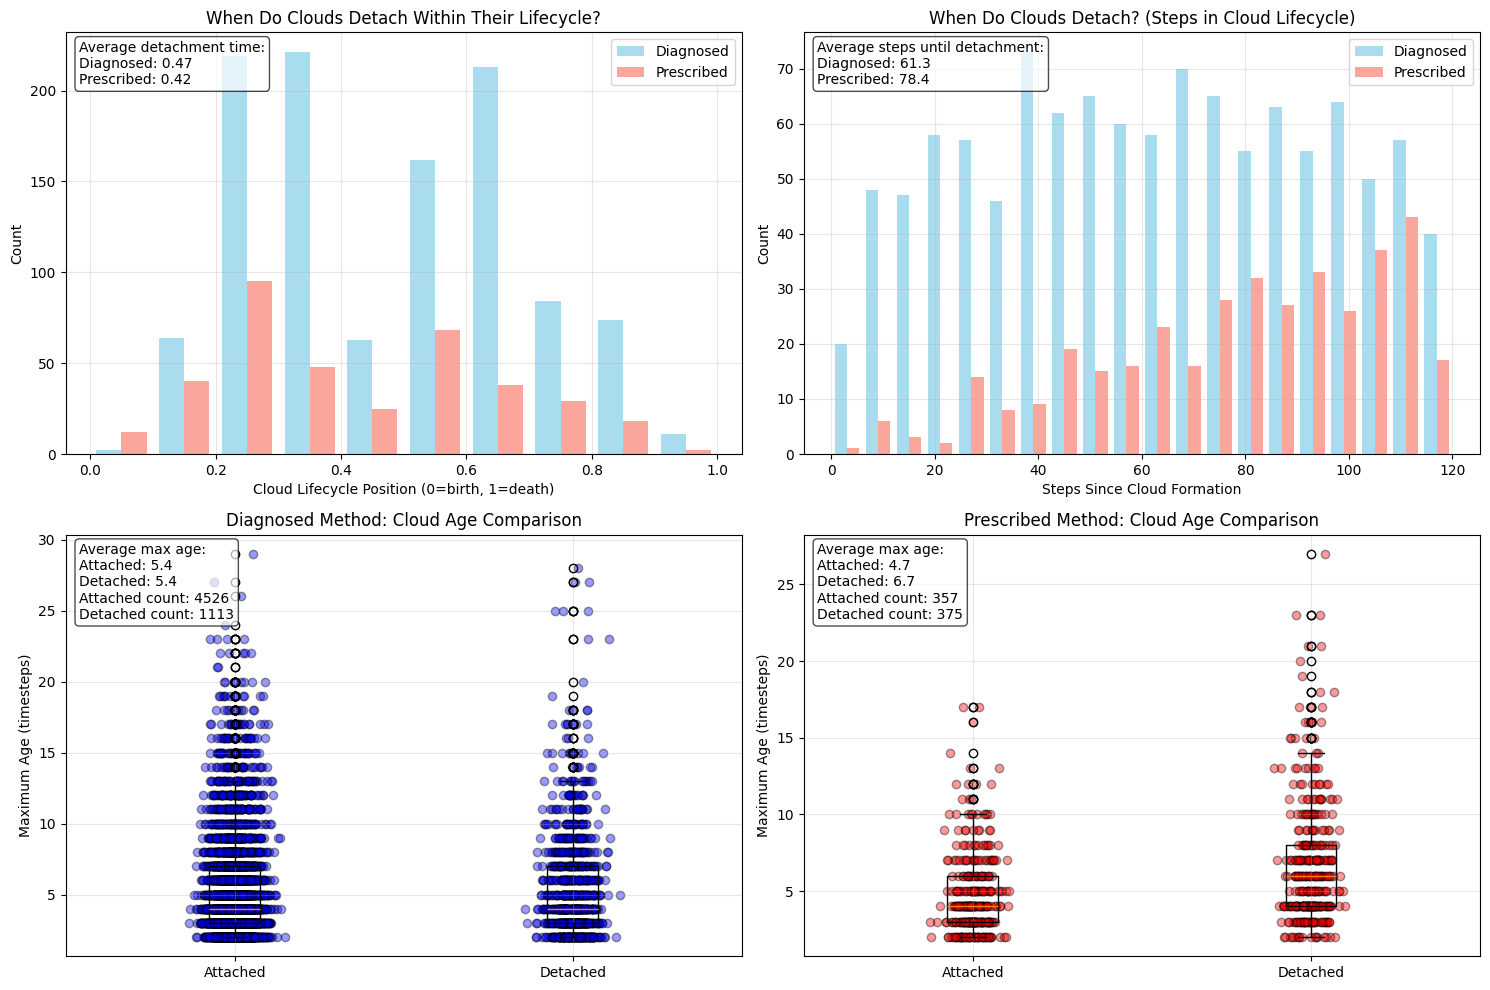

In [12]:
results = analyze_cloud_base_detachment_with_lifespan_plots(
    raw_data=raw,
    tracks_df=df_tracks,
    detachment_threshold=50,  # More strict definition of detachment
    min_lifetime_steps=3,      # Longer-lived clouds only
    min_size_points=20         # Larger clouds only
)

## How many detach, how many initiate above common cloud base?

## Cloud Detachment and Above-LCL Initiation Analysis

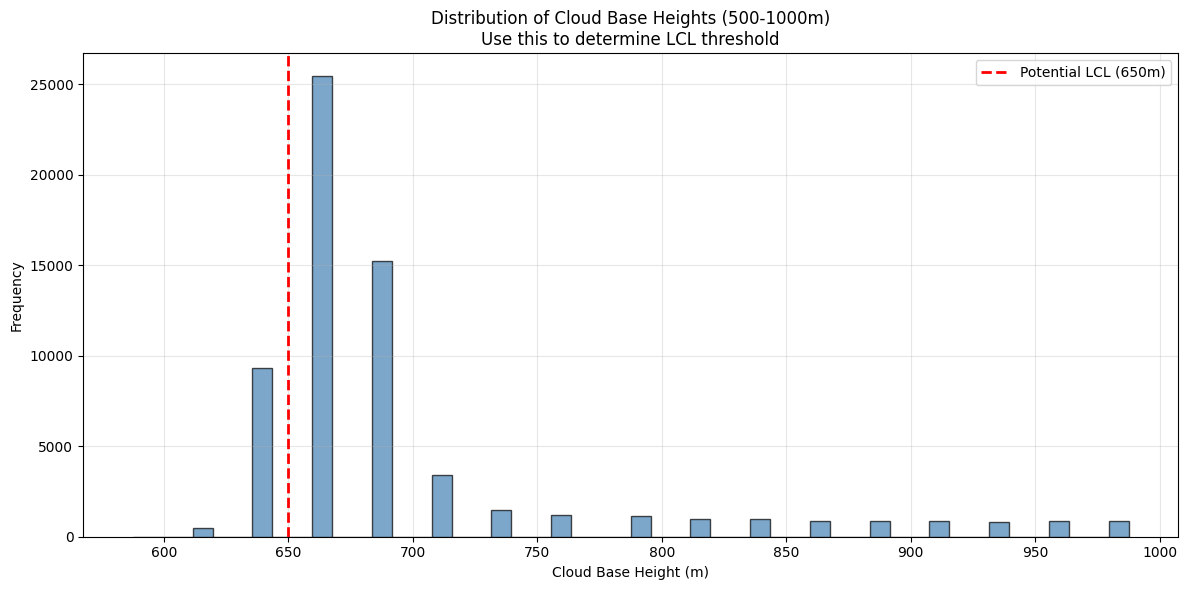

Total cloud base observations: 77,285
Observations in 500-1000m range: 64,815

Percentiles:
  10th percentile: 637.5m
  25th percentile: 662.5m
  50th percentile: 687.5m
  75th percentile: 812.5m
  90th percentile: 1137.5m


In [18]:
import numpy as np
# Plot cloud base height distribution to help determine LCL threshold

cloud_base_height = np.ma.filled(raw.get('cloud_base_height', None), np.nan)

# Collect all cloud base heights (flatten and remove NaNs)
all_cbh = cloud_base_height.flatten()
all_cbh = all_cbh[np.isfinite(all_cbh)]

# Focus on the range 500-1000m
cbh_filtered = all_cbh[(all_cbh >= 500) & (all_cbh <= 1000)]

# Create histogram
plt.figure(figsize=(12, 6))
plt.hist(cbh_filtered, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
plt.axvline(650, color='red', linestyle='--', linewidth=2, label='Potential LCL (650m)')
plt.xlabel('Cloud Base Height (m)')
plt.ylabel('Frequency')
plt.title('Distribution of Cloud Base Heights (500-1000m)\nUse this to determine LCL threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Total cloud base observations: {len(all_cbh):,}")
print(f"Observations in 500-1000m range: {len(cbh_filtered):,}")
print(f"\nPercentiles:")
for p in [10, 25, 50, 75, 90]:
    print(f"  {p}th percentile: {np.percentile(all_cbh, p):.1f}m")

In [22]:
def analyze_cloud_detachment(raw_data, tracks_df, 
                            lcl_threshold=700.0,
                            min_lifetime_steps=5,
                            min_max_size_points=100):
    """
    Analyze cloud detachment and above-LCL initiation.
    
    Definitions:
    - Detached: Cloud base rises above its initial height at some point
    - Above-LCL: Cloud base is NEVER below lcl_threshold during its lifetime
    
    Parameters:
    -----------
    raw_data : dict
        Must contain 'cloud_base_height', 'age', 'size'
    tracks_df : pd.DataFrame
        Track metadata with 'track_index', 'lifetime', 'max_size_points'
    lcl_threshold : float
        Height threshold for LCL (m)
    min_lifetime_steps : int
        Minimum cloud lifetime to include
    min_max_size_points : int
        Minimum peak cloud size to include
    
    Returns:
    --------
    dict with analysis results
    """
    
    # Extract arrays
    cbh = np.ma.filled(raw_data.get('cloud_base_height', None), np.nan)
    age = np.ma.filled(raw_data.get('age', None), np.nan)
    size = np.ma.filled(raw_data.get('size', None), np.nan)
    
    # Filter tracks
    filtered = tracks_df[
        (tracks_df['lifetime'] >= min_lifetime_steps) & 
        (tracks_df['max_size_points'] >= min_max_size_points)
    ]
    
    print(f"Analyzing {len(filtered)} clouds")
    print(f"Filters: lifetime ≥ {min_lifetime_steps} steps, size ≥ {min_max_size_points} points")
    print(f"LCL threshold: {lcl_threshold}m")
    print("="*70)
    
    detached = []
    above_lcl = []
    
    for idx, row in filtered.iterrows():
        track_idx = row['track_index']
        
        # Get valid timesteps
        cbh_series = cbh[track_idx, :]
        valid = np.isfinite(cbh_series) & np.isfinite(age[track_idx, :]) & (size[track_idx, :] > 0)
        
        if not np.any(valid):
            continue
            
        cbh_valid = cbh_series[valid]
        
        # Check if above-LCL (never below threshold)
        if np.all(cbh_valid > lcl_threshold):
            above_lcl.append(track_idx)
        
        # Check if detached (rises above initial height)
        initial_height = cbh_valid[0]
        max_height = np.max(cbh_valid)
        
        if max_height > initial_height:
            detached.append(track_idx)
    
    # Calculate fractions
    n_total = len(filtered)
    n_detached = len(detached)
    n_above_lcl = len(above_lcl)
    
    frac_detached = n_detached / n_total if n_total > 0 else 0
    frac_above_lcl = n_above_lcl / n_total if n_total > 0 else 0
    
    # Print results
    print(f"\nRESULTS:")
    print(f"Total clouds: {n_total}")
    print(f"Detached (rose above initial height): {n_detached} ({frac_detached*100:.1f}%)")
    print(f"Above-LCL (never below {lcl_threshold}m): {n_above_lcl} ({frac_above_lcl*100:.1f}%)")
    
    return {
        'n_total': n_total,
        'n_detached': n_detached,
        'n_above_lcl': n_above_lcl,
        'frac_detached': frac_detached,
        'frac_above_lcl': frac_above_lcl,
        'detached_tracks': detached,
        'above_lcl_tracks': above_lcl
    }

# Run analysis with default parameters
results = analyze_cloud_detachment(
    raw, df_tracks,
    lcl_threshold=700.0,
    min_lifetime_steps=5,
    min_max_size_points=100
)

Analyzing 2053 clouds
Filters: lifetime ≥ 5 steps, size ≥ 100 points
LCL threshold: 700.0m

RESULTS:
Total clouds: 2053
Detached (rose above initial height): 1007 (49.1%)
Above-LCL (never below 700.0m): 160 (7.8%)


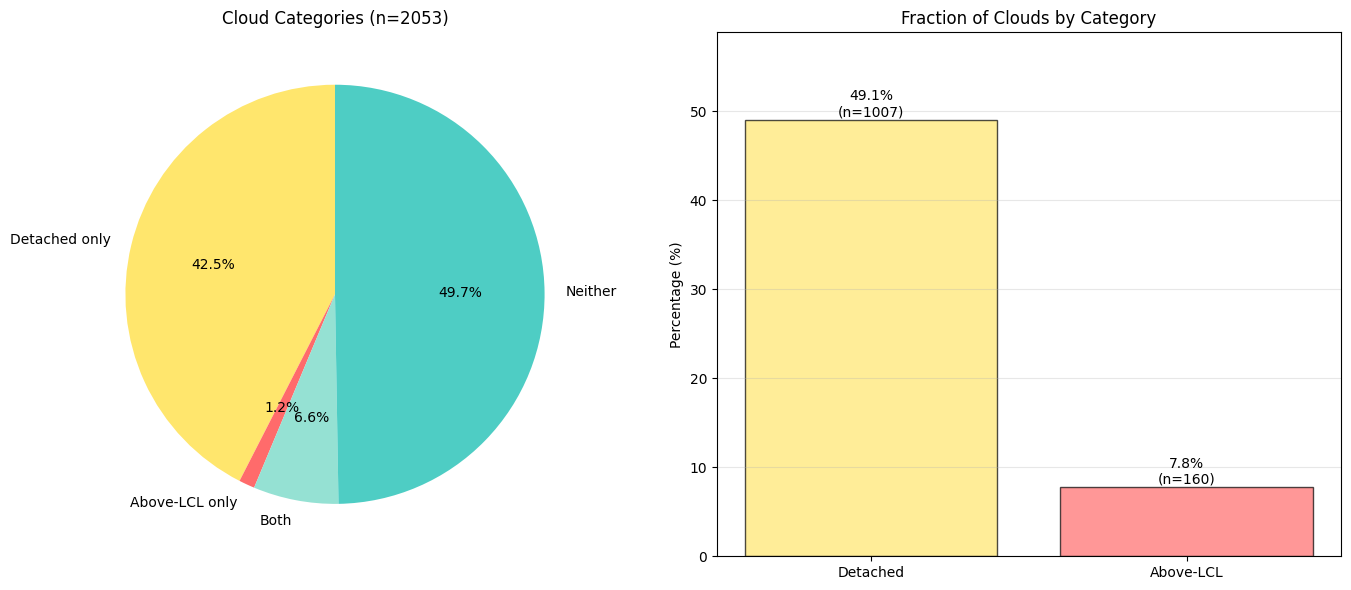

In [20]:
# Visualize results

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Pie chart
ax1 = axes[0]
categories = ['Detached', 'Above-LCL only', 'Neither']
n_detached = results['n_detached']
n_above_lcl = results['n_above_lcl']
n_total = results['n_total']

# Count clouds in each category (some may be in both)
both = len(set(results['detached_tracks']) & set(results['above_lcl_tracks']))
only_detached = n_detached - both
only_above_lcl = n_above_lcl - both
neither = n_total - only_detached - only_above_lcl - both

counts = [only_detached, only_above_lcl, both, neither]
labels = ['Detached only', 'Above-LCL only', 'Both', 'Neither']
colors = ['#FFE66D', '#FF6B6B', '#95E1D3', '#4ECDC4']

ax1.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
ax1.set_title(f'Cloud Categories (n={n_total})')

# Bar chart
ax2 = axes[1]
categories = ['Detached', 'Above-LCL']
percentages = [results['frac_detached']*100, results['frac_above_lcl']*100]
bars = ax2.bar(categories, percentages, color=['#FFE66D', '#FF6B6B'], edgecolor='black', alpha=0.7)

for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{pct:.1f}%\n(n={int(pct*n_total/100)})',
            ha='center', va='bottom')

ax2.set_ylabel('Percentage (%)')
ax2.set_title('Fraction of Clouds by Category')
ax2.set_ylim(0, max(percentages)*1.2)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

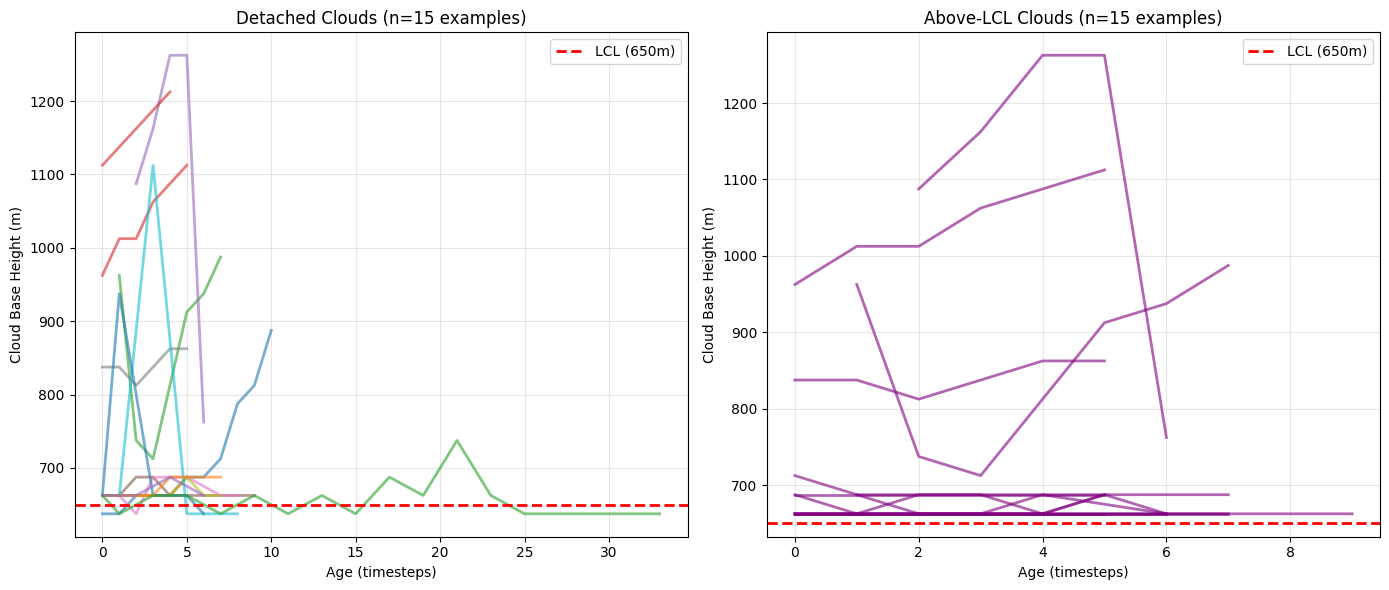

In [9]:
# Plot example trajectories

cbh = np.ma.filled(raw.get('cloud_base_height', None), np.nan)
age = np.ma.filled(raw.get('age', None), np.nan)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot detached clouds
ax1 = axes[0]
for track_idx in results['detached_tracks'][:15]:
    cbh_series = cbh[track_idx, :]
    age_series = age[track_idx, :]
    valid = np.isfinite(cbh_series) & np.isfinite(age_series)
    
    if np.any(valid):
        ax1.plot(age_series[valid], cbh_series[valid], alpha=0.6, linewidth=2)

ax1.axhline(650, color='red', linestyle='--', linewidth=2, label='LCL (650m)')
ax1.set_xlabel('Age (timesteps)')
ax1.set_ylabel('Cloud Base Height (m)')
ax1.set_title(f'Detached Clouds (n={min(15, len(results["detached_tracks"]))} examples)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot above-LCL clouds
ax2 = axes[1]
for track_idx in results['above_lcl_tracks'][:15]:
    cbh_series = cbh[track_idx, :]
    age_series = age[track_idx, :]
    valid = np.isfinite(cbh_series) & np.isfinite(age_series)
    
    if np.any(valid):
        ax2.plot(age_series[valid], cbh_series[valid], alpha=0.6, linewidth=2, color='purple')

ax2.axhline(650, color='red', linestyle='--', linewidth=2, label='LCL (650m)')
ax2.set_xlabel('Age (timesteps)')
ax2.set_ylabel('Cloud Base Height (m)')
ax2.set_title(f'Above-LCL Clouds (n={min(15, len(results["above_lcl_tracks"]))} examples)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
# Run with different parameters - EDIT THESE VALUES

results_custom = analyze_cloud_detachment(
    raw, df_tracks,
    lcl_threshold=650.0,           # Change this based on histogram above
    min_lifetime_steps=10,         # Try different values
    min_max_size_points=200        # Try different values
)

Analyzing 17 clouds
Filters: lifetime ≥ 10 steps, size ≥ 200 points
LCL threshold: 650.0m

RESULTS:
Total clouds: 17
Detached (rose above initial height): 12 (70.6%)
Above-LCL (never below 650.0m): 9 (52.9%)


Analyzing 5639 clouds
Filters: lifetime ≥ 3 steps, size ≥ 50 points
LCL threshold: 650.0m

RESULTS:
Total clouds: 5639
Detached (rose above initial height): 2288 (40.6%)
Above-LCL (never below 650.0m): 3803 (67.4%)

Analyzing 5639 clouds
Filters: lifetime ≥ 3 steps, size ≥ 100 points
LCL threshold: 650.0m

RESULTS:
Total clouds: 5639
Detached (rose above initial height): 2288 (40.6%)
Above-LCL (never below 650.0m): 3803 (67.4%)

Analyzing 4957 clouds
Filters: lifetime ≥ 3 steps, size ≥ 200 points
LCL threshold: 650.0m

RESULTS:
Total clouds: 4957
Detached (rose above initial height): 1954 (39.4%)
Above-LCL (never below 650.0m): 3184 (64.2%)

Analyzing 3791 clouds
Filters: lifetime ≥ 3 steps, size ≥ 500 points
LCL threshold: 650.0m

RESULTS:
Total clouds: 3791
Detached (rose above initial height): 1399 (36.9%)
Above-LCL (never below 650.0m): 2203 (58.1%)

Analyzing 2053 clouds
Filters: lifetime ≥ 5 steps, size ≥ 50 points
LCL threshold: 650.0m

RESULTS:
Total clouds: 2053
Detached (rose

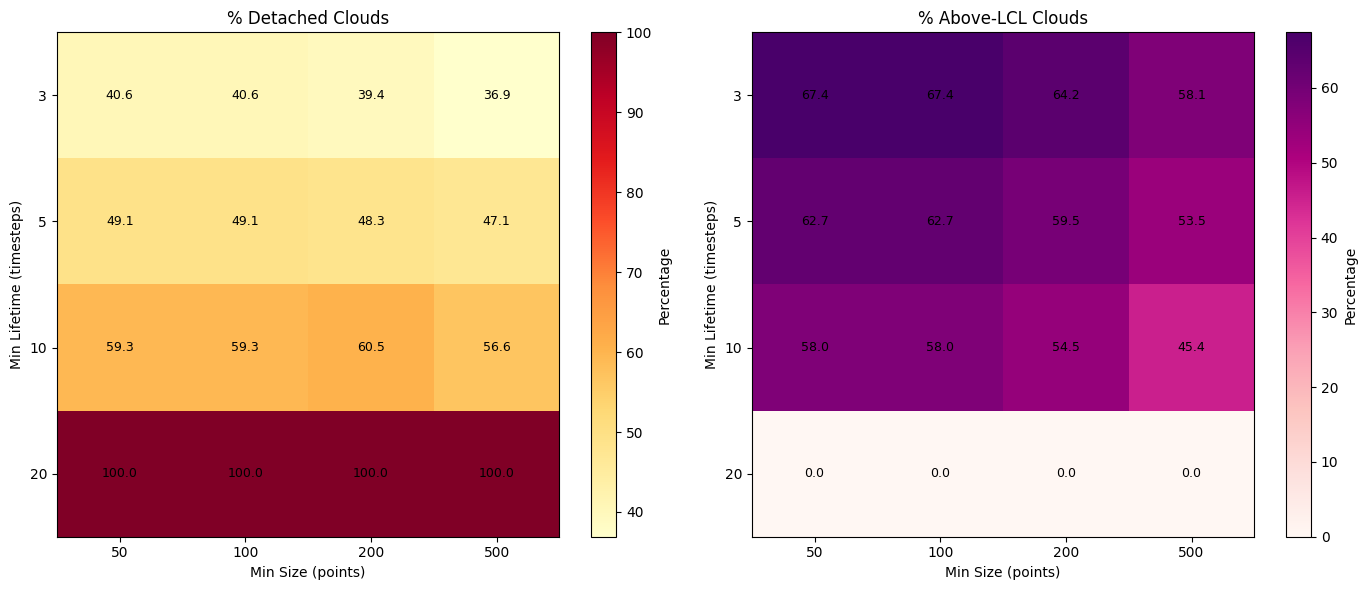

In [23]:
# Sensitivity analysis: test different filter combinations

sensitivity_results = []

for min_life in [3, 5, 10, 20]:
    for min_size in [50, 100, 200, 500]:
        result = analyze_cloud_detachment(
            raw, df_tracks,
            lcl_threshold=650.0,
            min_lifetime_steps=min_life,
            min_max_size_points=min_size
        )
        
        sensitivity_results.append({
            'min_lifetime': min_life,
            'min_size': min_size,
            'n_clouds': result['n_total'],
            'pct_detached': result['frac_detached'] * 100,
            'pct_above_lcl': result['frac_above_lcl'] * 100
        })
        print()

# Create summary table
sens_df = pd.DataFrame(sensitivity_results)
print("\n" + "="*70)
print("SENSITIVITY ANALYSIS SUMMARY")
print("="*70)
print(sens_df.to_string(index=False))

# Visualize sensitivity
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Detached percentage
pivot_detached = sens_df.pivot(index='min_lifetime', columns='min_size', values='pct_detached')
im1 = axes[0].imshow(pivot_detached.values, cmap='YlOrRd', aspect='auto')
axes[0].set_xticks(range(len(pivot_detached.columns)))
axes[0].set_yticks(range(len(pivot_detached.index)))
axes[0].set_xticklabels(pivot_detached.columns)
axes[0].set_yticklabels(pivot_detached.index)
axes[0].set_xlabel('Min Size (points)')
axes[0].set_ylabel('Min Lifetime (timesteps)')
axes[0].set_title('% Detached Clouds')

for i in range(len(pivot_detached.index)):
    for j in range(len(pivot_detached.columns)):
        axes[0].text(j, i, f'{pivot_detached.values[i, j]:.1f}',
                    ha="center", va="center", color="black", fontsize=9)

plt.colorbar(im1, ax=axes[0], label='Percentage')

# Above-LCL percentage
pivot_above = sens_df.pivot(index='min_lifetime', columns='min_size', values='pct_above_lcl')
im2 = axes[1].imshow(pivot_above.values, cmap='RdPu', aspect='auto')
axes[1].set_xticks(range(len(pivot_above.columns)))
axes[1].set_yticks(range(len(pivot_above.index)))
axes[1].set_xticklabels(pivot_above.columns)
axes[1].set_yticklabels(pivot_above.index)
axes[1].set_xlabel('Min Size (points)')
axes[1].set_ylabel('Min Lifetime (timesteps)')
axes[1].set_title('% Above-LCL Clouds')

for i in range(len(pivot_above.index)):
    for j in range(len(pivot_above.columns)):
        axes[1].text(j, i, f'{pivot_above.values[i, j]:.1f}',
                    ha="center", va="center", color="black", fontsize=9)

plt.colorbar(im2, ax=axes[1], label='Percentage')

plt.tight_layout()
plt.show()

Saved: analysis_plots/lifetime_vs_detachment_above_lcl.pdf


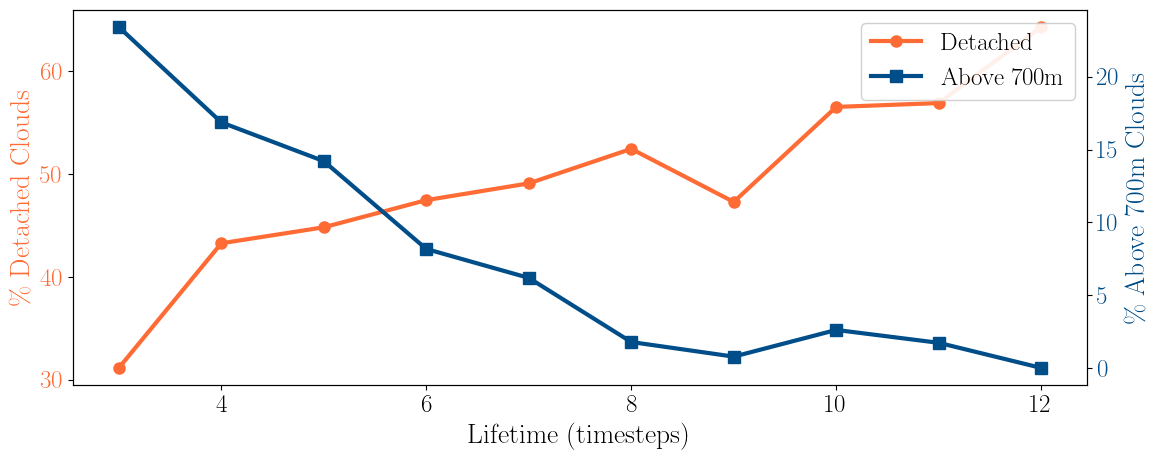


Bin summary (n_clouds per bin): [2234, 1352, 676, 453, 275, 225, 129, 115, 58, 42]


In [32]:
# Dual-axis plot: Lifetime vs Detachment/Above-LCL percentages

# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 20

# First, classify all clouds once
cbh = np.ma.filled(raw.get('cloud_base_height', None), np.nan)
age_arr = np.ma.filled(raw.get('age', None), np.nan)
size_arr = np.ma.filled(raw.get('size', None), np.nan)

# Filter tracks
filtered_df = df_tracks[df_tracks['max_size_points'] >= 50].copy()

# Classify each cloud
detached_status = []
above_lcl_status = []

for idx, row in filtered_df.iterrows():
    track_idx = row['track_index']
    cbh_series = cbh[track_idx, :]
    valid = np.isfinite(cbh_series) & np.isfinite(age_arr[track_idx, :]) & (size_arr[track_idx, :] > 0)
    
    if not np.any(valid):
        detached_status.append(False)
        above_lcl_status.append(False)
        continue
    
    cbh_valid = cbh_series[valid]
    
    # Check detachment and above-LCL
    detached = np.max(cbh_valid) > cbh_valid[0]
    above_lcl = np.all(cbh_valid > 700.0)
    
    detached_status.append(detached)
    above_lcl_status.append(above_lcl)

filtered_df['detached'] = detached_status
filtered_df['above_lcl'] = above_lcl_status

# Calculate percentage for each individual lifetime value from 3 to 20
lifetimes = []
detached_pct = []
above_lcl_pct = []
n_clouds = []

for life in range(3, 13):  # 3 to 20 inclusive
    life_data = filtered_df[filtered_df['lifetime'] == life]
    
    if len(life_data) > 0:  # Include all lifetimes with at least 1 cloud
        lifetimes.append(life)
        detached_pct.append(100 * life_data['detached'].sum() / len(life_data))
        above_lcl_pct.append(100 * life_data['above_lcl'].sum() / len(life_data))
        n_clouds.append(len(life_data))

# Create figure with dual y-axes
fig, ax1 = plt.subplots(figsize=(12, 5))
fig.patch.set_alpha(0.0)  # Transparent background
ax1.patch.set_alpha(0.0)

# Left y-axis: Detached clouds
color1 = '#FF6B35'
ax1.set_xlabel(r'Lifetime (timesteps)', fontsize=20)
ax1.set_ylabel(r'\% Detached Clouds', color=color1, fontsize=20)
line1 = ax1.plot(lifetimes, detached_pct, color=color1, linewidth=3, 
                 marker='o', markersize=8, label='Detached')
ax1.tick_params(axis='y', labelcolor=color1, labelsize=18)
ax1.tick_params(axis='x', labelsize=18)

# Right y-axis: Above-LCL clouds
ax2 = ax1.twinx()
color2 = '#004E89'
ax2.set_ylabel(r'\% Above 700m Clouds', color=color2, fontsize=20)
line2 = ax2.plot(lifetimes, above_lcl_pct, color=color2, linewidth=3, 
                 marker='s', markersize=8, label='Above 700m')
ax2.tick_params(axis='y', labelcolor=color2, labelsize=18)

# Add legend
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right', fontsize=18, framealpha=0.9)

plt.tight_layout()

# Save as PDF
plt.savefig('analysis_plots/lifetime_vs_detachment_above_lcl.pdf', 
            format='pdf', dpi=300, transparent=True, bbox_inches='tight')
print("Saved: analysis_plots/lifetime_vs_detachment_above_lcl.pdf")

plt.show()

# Reset matplotlib settings
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 10

print(f"\nBin summary (n_clouds per bin): {n_clouds}")

Saved: analysis_plots/lifetime_vs_detachment_above_lcl_with_errors.pdf


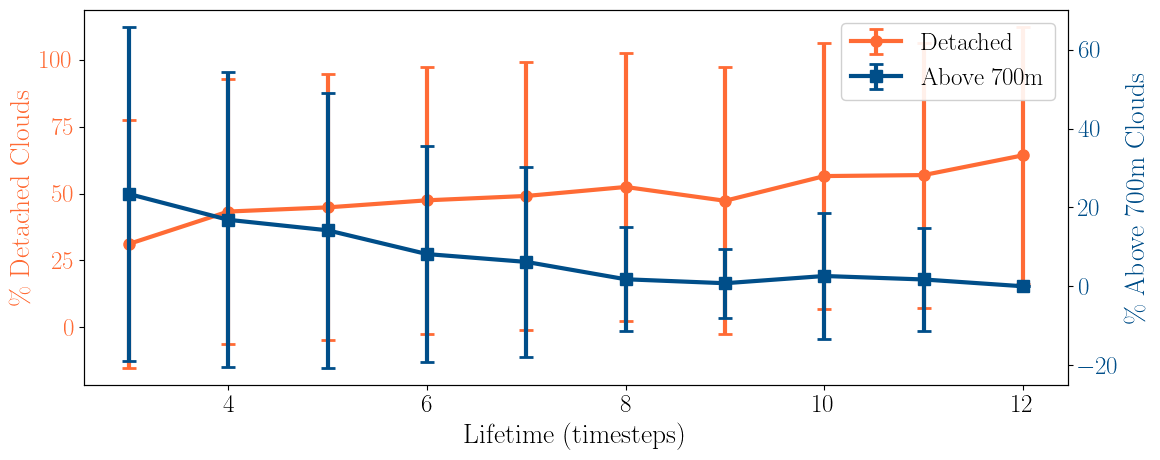


Sample sizes per lifetime: [2234, 1352, 676, 453, 275, 225, 129, 115, 58, 42]


In [34]:
# Same plot but with error bars showing one standard deviation

# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 20

# Reuse the classification from previous cell
# Calculate percentage and standard deviation for each lifetime
lifetimes = []
detached_pct = []
above_lcl_pct = []
detached_err = []
above_lcl_err = []
n_clouds = []

for life in range(3, 13):
    life_data = filtered_df[filtered_df['lifetime'] == life]
    
    if len(life_data) > 0:
        n = len(life_data)
        lifetimes.append(life)
        n_clouds.append(n)
        
        # Calculate percentages
        p_detached = life_data['detached'].sum() / n
        p_above = life_data['above_lcl'].sum() / n
        
        detached_pct.append(100 * p_detached)
        above_lcl_pct.append(100 * p_above)
        
        # Standard deviation for binomial proportion: sqrt(p*(1-p))
        detached_err.append(100 * np.sqrt(p_detached * (1 - p_detached)))
        above_lcl_err.append(100 * np.sqrt(p_above * (1 - p_above)))

# Create figure with dual y-axes
fig, ax1 = plt.subplots(figsize=(12, 5))
fig.patch.set_alpha(0.0)
ax1.patch.set_alpha(0.0)

# Left y-axis: Detached clouds
color1 = '#FF6B35'
ax1.set_xlabel(r'Lifetime (timesteps)', fontsize=20)
ax1.set_ylabel(r'\% Detached Clouds', color=color1, fontsize=20)
ax1.errorbar(lifetimes, detached_pct, yerr=detached_err, 
             color=color1, linewidth=3, marker='o', markersize=8, 
             capsize=5, capthick=2, label='Detached')
ax1.tick_params(axis='y', labelcolor=color1, labelsize=18)
ax1.tick_params(axis='x', labelsize=18)

# Right y-axis: Above-LCL clouds
ax2 = ax1.twinx()
color2 = '#004E89'
ax2.set_ylabel(r'\% Above 700m Clouds', color=color2, fontsize=20)
ax2.errorbar(lifetimes, above_lcl_pct, yerr=above_lcl_err,
             color=color2, linewidth=3, marker='s', markersize=8,
             capsize=5, capthick=2, label='Above 700m')
ax2.tick_params(axis='y', labelcolor=color2, labelsize=18)

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=18, framealpha=0.9)

plt.tight_layout()

# Save as PDF
plt.savefig('analysis_plots/lifetime_vs_detachment_above_lcl_with_errors.pdf', 
            format='pdf', dpi=300, transparent=True, bbox_inches='tight')
print("Saved: analysis_plots/lifetime_vs_detachment_above_lcl_with_errors.pdf")

plt.show()

# Reset matplotlib settings
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 10

print(f"\nSample sizes per lifetime: {n_clouds}")

# Checking NIP

Included tracks: 15933 / 100000
NIP base-level samples: 48769
Base NIP: median=0.000000, IQR=(0.000000,0.000000)
Base NIP_acc: median= 0.000000


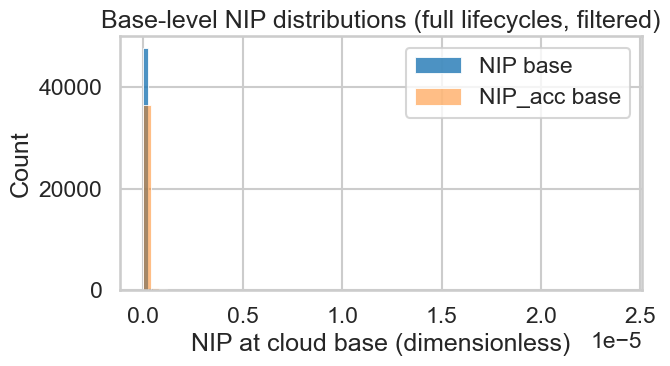

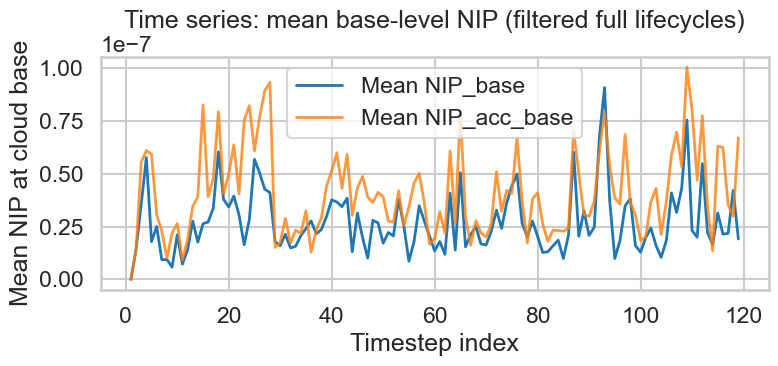

In [13]:
# PARAMETERS
NC_FILE = "../output_archive/cloud_results_120mins.nc"
MIN_MAX_SIZE_POINTS = 10     # track must reach at least this many voxels once
MIN_LIFETIME_STEPS = 2        # track must exist (non-NaN size) at least this many timesteps

# IMPORTS
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from netCDF4 import Dataset

sns.set_context("talk")
sns.set_style("whitegrid")

# ---- Load variables (filled with NaN where masked/missing) ----
def read_opt(ds, name):
    var = ds.variables.get(name)
    if var is None:
        return None
    data = var[:]
    if np.issubdtype(data.dtype, np.integer):
        return np.ma.filled(data.astype(np.float64), np.nan)
    return np.ma.filled(data, np.nan)

with Dataset(NC_FILE) as ds:
    valid_track = np.asarray(ds.variables['valid_track'][:])  # 1=complete lifecycle
    size = np.ma.filled(ds.variables['size'][:], np.nan)      # (track,time)
    height = np.asarray(ds.variables['height'][:])            # (level,)
    cbh = read_opt(ds, 'cloud_base_height')                   # (track,time)
    nip = read_opt(ds, 'nip_per_level')                       # (track,time,level)
    nip_acc = read_opt(ds, 'nip_acc_per_level')               # (track,time,level)

if nip is None or nip_acc is None or cbh is None:
    raise RuntimeError("Missing NIP variables or cloud_base_height in NetCDF. Re-run tracking with NIP enabled.")

n_tracks, n_times = size.shape
n_levels = height.shape[0]
valid_mask_tracks = (valid_track == 1)

# ---- Filter to full lifecycles with minimum size and lifetime ----
include_track = np.zeros(n_tracks, dtype=bool)
for i in range(n_tracks):
    if not valid_mask_tracks[i]:
        continue
    size_row = size[i]                    # (time,)
    time_valid = np.isfinite(size_row)    # cloud exists at these times
    lifetime = int(time_valid.sum())
    if lifetime < MIN_LIFETIME_STEPS:
        continue
    max_size = np.nanmax(size_row[time_valid]) if lifetime > 0 else np.nan
    if not np.isfinite(max_size) or max_size < MIN_MAX_SIZE_POINTS:
        continue
    include_track[i] = True

# ---- Collect base-level NIP and NIP_acc over all included tracks/times ----
nip_base_all = []
nip_acc_base_all = []

# For a simple time series, collect mean over included tracks at each timestep
nip_base_mean_ts = np.full(n_times, np.nan)
nip_acc_base_mean_ts = np.full(n_times, np.nan)

def nearest_level_index(levels, target):
    # vectorized nearest index for 1D levels array and target scalar
    return int(np.abs(levels - target).argmin())

for t in range(n_times):
    tb_values = []
    tb_acc_values = []
    for i in np.where(include_track)[0]:
        # cloud exists and has a base height at this time?
        if not (np.isfinite(size[i, t]) and np.isfinite(cbh[i, t])):
            continue
        # need at least one finite NIP level at this time
        nip_it = nip[i, t, :]
        nip_acc_it = nip_acc[i, t, :]
        if not np.isfinite(nip_it).any():
            continue
        bidx = nearest_level_index(height, cbh[i, t])
        # guard index
        if bidx < 0 or bidx >= n_levels:
            continue
        v = nip_it[bidx]
        va = nip_acc_it[bidx]
        if np.isfinite(v):
            nip_base_all.append(v)
            tb_values.append(v)
        if np.isfinite(va):
            nip_acc_base_all.append(va)
            tb_acc_values.append(va)

    # time-mean across included tracks at time t
    if tb_values:
        nip_base_mean_ts[t] = float(np.nanmean(tb_values))
    if tb_acc_values:
        nip_acc_base_mean_ts[t] = float(np.nanmean(tb_acc_values))

nip_base_all = np.array(nip_base_all) if len(nip_base_all) else np.array([])
nip_acc_base_all = np.array(nip_acc_base_all) if len(nip_acc_base_all) else np.array([])

print(f"Included tracks: {include_track.sum()} / {n_tracks}")
print(f"NIP base-level samples: {nip_base_all.size}")
if nip_base_all.size:
    print(f"Base NIP: median={np.nanmedian(nip_base_all):.6f}, "
          f"IQR=({np.nanpercentile(nip_base_all,25):.6f},{np.nanpercentile(nip_base_all,75):.6f})")
if nip_acc_base_all.size:
    print(f"Base NIP_acc: median={np.nanmedian(nip_acc_base_all): .6f}")

# ---- Plot 1: Histogram of base-level NIP and NIP_acc (simple) ----
plt.figure(figsize=(7,4))
if nip_base_all.size:
    sns.histplot(nip_base_all, bins=60, color='tab:blue', alpha=0.8, label='NIP base')
if nip_acc_base_all.size:
    sns.histplot(nip_acc_base_all, bins=60, color='tab:orange', alpha=0.5, label='NIP_acc base')
plt.xlabel('NIP at cloud base (dimensionless)')
plt.ylabel('Count')
plt.title('Base-level NIP distributions (full lifecycles, filtered)')
plt.legend()
plt.tight_layout()
plt.show()

# ---- Plot 2: Time series of domain-mean base-level NIP and NIP_acc ----
plt.figure(figsize=(8,4))
if np.isfinite(nip_base_mean_ts).any():
    plt.plot(nip_base_mean_ts, label='Mean NIP_base', lw=2)
if np.isfinite(nip_acc_base_mean_ts).any():
    plt.plot(nip_acc_base_mean_ts, label='Mean NIP_acc_base', lw=2, alpha=0.8)
plt.xlabel('Timestep index')
plt.ylabel('Mean NIP at cloud base')
plt.title('Time series: mean base-level NIP (filtered full lifecycles)')
plt.legend()
plt.tight_layout()
plt.show()


Included tracks: 5639 / 100000
Base NIP samples: 26565  | zeros: 25091  | positives: 1474
Base NIP_acc samples: 19604  | zeros: 18544  | positives: 1060
NIP_base positives: min=2.906e-10, median=1.655e-07, p90=9.973e-07, max=1.518e-05
NIP_acc_base positives: min=2.906e-10, median=1.844e-07, p90=1.819e-06, max=2.388e-05


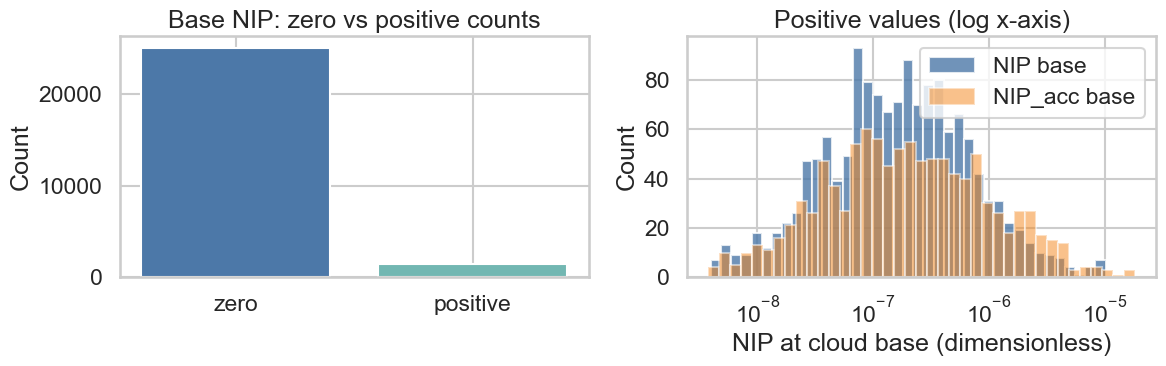

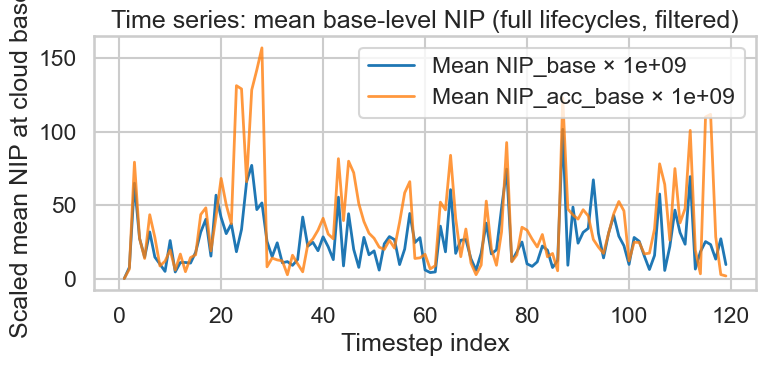

In [14]:
# PARAMETERS
NC_FILE = "../output_archive/cloud_results_120mins.nc"
MIN_MAX_SIZE_POINTS = 100
MIN_LIFETIME_STEPS = 3
EPS_NEAR_ZERO = 1e-15    # treat |x| < EPS as “zero” for plotting/reporting
TS_SCALE = 1e9           # scale time-series to show tiny values; set to 1.0 to disable

# IMPORTS
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from netCDF4 import Dataset

sns.set_context("talk")
sns.set_style("whitegrid")

def read_opt(ds, name):
    var = ds.variables.get(name)
    if var is None:
        return None
    data = var[:]
    if np.issubdtype(data.dtype, np.integer):
        return np.ma.filled(data.astype(np.float64), np.nan)
    return np.ma.filled(data, np.nan)

def nearest_level_index(levels, target):
    return int(np.abs(levels - target).argmin())

# -------- Load and filter --------
with Dataset(NC_FILE) as ds:
    valid_track = np.asarray(ds.variables['valid_track'][:])  # 1=complete lifecycle
    size = np.ma.filled(ds.variables['size'][:], np.nan)      # (track,time)
    height = np.asarray(ds.variables['height'][:])            # (level,)
    cbh = read_opt(ds, 'cloud_base_height')                   # (track,time)
    nip = read_opt(ds, 'nip_per_level')                       # (track,time,level)
    nip_acc = read_opt(ds, 'nip_acc_per_level')               # (track,time,level)

if nip is None or nip_acc is None or cbh is None:
    raise RuntimeError("Missing NIP variables or cloud_base_height in NetCDF.")

n_tracks, n_times = size.shape
n_levels = height.shape[0]
valid_mask_tracks = (valid_track == 1)

# track filter
include_track = np.zeros(n_tracks, dtype=bool)
for i in range(n_tracks):
    if not valid_mask_tracks[i]:
        continue
    size_row = size[i]
    time_valid = np.isfinite(size_row)
    lifetime = int(time_valid.sum())
    if lifetime < MIN_LIFETIME_STEPS:
        continue
    max_size = np.nanmax(size_row[time_valid]) if lifetime > 0 else np.nan
    if not np.isfinite(max_size) or max_size < MIN_MAX_SIZE_POINTS:
        continue
    include_track[i] = True

# -------- Collect base-level samples and time series --------
nip_base_all, nip_acc_base_all = [], []
nip_base_mean_ts = np.full(n_times, np.nan)
nip_acc_base_mean_ts = np.full(n_times, np.nan)

for t in range(n_times):
    tb, tba = [], []
    for i in np.where(include_track)[0]:
        if not (np.isfinite(size[i, t]) and np.isfinite(cbh[i, t])):
            continue
        nip_it = nip[i, t, :]
        nip_acc_it = nip_acc[i, t, :]
        if not np.isfinite(nip_it).any():
            continue
        bidx = nearest_level_index(height, cbh[i, t])
        if bidx < 0 or bidx >= n_levels:
            continue
        v = nip_it[bidx]
        va = nip_acc_it[bidx]
        if np.isfinite(v):
            nip_base_all.append(v); tb.append(v)
        if np.isfinite(va):
            nip_acc_base_all.append(va); tba.append(va)
    if tb:
        nip_base_mean_ts[t] = float(np.nanmean(tb))
    if tba:
        nip_acc_base_mean_ts[t] = float(np.nanmean(tba))

nip_base_all = np.array(nip_base_all) if len(nip_base_all) else np.array([])
nip_acc_base_all = np.array(nip_acc_base_all) if len(nip_acc_base_all) else np.array([])

# -------- Split zeros vs positives; build log bins --------
def split_zero_positive(arr, eps=EPS_NEAR_ZERO):
    if arr.size == 0:
        return np.array([]), np.array([])
    zeros = arr[np.abs(arr) < eps]
    pos = arr[arr >= eps]
    return zeros, pos

z_base, p_base = split_zero_positive(nip_base_all)
z_acc, p_acc = split_zero_positive(nip_acc_base_all)

def log_bins(x, nbins=40, q_low=1, q_high=99.9):
    x = x[np.isfinite(x)]
    if x.size == 0:
        return None
    lo = max(np.nanmin(x[x > 0]) if np.any(x > 0) else np.nan, np.nanpercentile(x, q_low))
    hi = np.nanpercentile(x, q_high)
    if not (np.isfinite(lo) and np.isfinite(hi)) or lo <= 0 or hi <= lo:
        return None
    return np.logspace(np.log10(lo), np.log10(hi), nbins)

# bins for positive values
bins_base = log_bins(p_base)
bins_acc = log_bins(p_acc)

# -------- Print quick stats --------
print(f"Included tracks: {include_track.sum()} / {n_tracks}")
print(f"Base NIP samples: {nip_base_all.size}  | zeros: {z_base.size}  | positives: {p_base.size}")
print(f"Base NIP_acc samples: {nip_acc_base_all.size}  | zeros: {z_acc.size}  | positives: {p_acc.size}")
if p_base.size:
    print(f"NIP_base positives: min={p_base.min():.3e}, median={np.median(p_base):.3e}, p90={np.percentile(p_base,90):.3e}, max={p_base.max():.3e}")
if p_acc.size:
    print(f"NIP_acc_base positives: min={p_acc.min():.3e}, median={np.median(p_acc):.3e}, p90={np.percentile(p_acc,90):.3e}, max={p_acc.max():.3e}")

# -------- Plot A: zero vs positive counts + log-binned hist for positives --------
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left: NIP base
axes[0].bar(['zero', 'positive'], [z_base.size, p_base.size], color=['#4c78a8','#72b7b2'])
axes[0].set_title('Base NIP: zero vs positive counts')
axes[0].set_ylabel('Count')

# Right: log-binned positive histogram (NIP base and NIP_acc base)
if p_base.size:
    if bins_base is None:
        axes[1].hist(p_base, bins=40, alpha=0.8, label='NIP base', color='#4c78a8')
    else:
        axes[1].hist(p_base, bins=bins_base, alpha=0.8, label='NIP base', color='#4c78a8')
if p_acc.size:
    if bins_acc is None:
        axes[1].hist(p_acc, bins=40, alpha=0.5, label='NIP_acc base', color='#f58518')
    else:
        axes[1].hist(p_acc, bins=bins_acc, alpha=0.5, label='NIP_acc base', color='#f58518')
axes[1].set_xscale('log')
axes[1].set_title('Positive values (log x-axis)')
axes[1].set_xlabel('NIP at cloud base (dimensionless)')
axes[1].set_ylabel('Count')
axes[1].legend()

plt.tight_layout()
plt.show()

# -------- Plot B: time series (scaled) --------
scale = TS_SCALE
plt.figure(figsize=(8, 4))
if np.isfinite(nip_base_mean_ts).any():
    plt.plot(nip_base_mean_ts * scale, label=f'Mean NIP_base × {scale:g}', lw=2)
if np.isfinite(nip_acc_base_mean_ts).any():
    plt.plot(nip_acc_base_mean_ts * scale, label=f'Mean NIP_acc_base × {scale:g}', lw=2, alpha=0.8)
plt.xlabel('Timestep index')
plt.ylabel('Scaled mean NIP at cloud base')
plt.title('Time series: mean base-level NIP (full lifecycles, filtered)')
plt.legend()
plt.tight_layout()
plt.show()


Tracks included: 13178


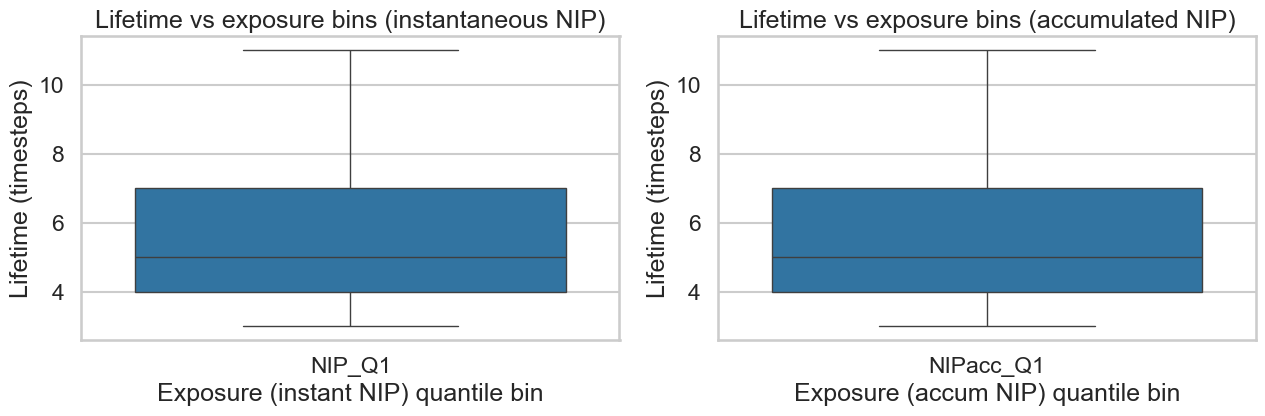


Instant NIP bins — counts/median lifetime:
              count_tracks  median_life
exp_bin_nip                           
NIP_Q1              13178          5.0

Accum NIP bins — counts/median lifetime:
                  count_tracks  median_life
exp_bin_nip_acc                           
NIPacc_Q1               13178          5.0


/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_14467/1817776381.py:179: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = (df.groupby('exp_bin_nip')['lifetime'].agg(['count','median'])
/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_14467/1817776381.py:181: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_acc = (df.groupby('exp_bin_nip_acc')['lifetime'].agg(['count','median'])


In [16]:
# PARAMETERS
NC_FILE = "../output_archive/cloud_results_120mins.nc"
MIN_MAX_SIZE_POINTS = 10      # track must reach at least this many voxels once
MIN_LIFETIME_STEPS = 3         # lifetime in steps (using age)
N_BINS = 5                     # exposure quantile bins
PLOT_KIND = "box"              # "box" or "violin"

# IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from netCDF4 import Dataset

sns.set_context("talk")
sns.set_style("whitegrid")

def read_opt(ds, name):
    var = ds.variables.get(name)
    if var is None:
        return None
    data = var[:]
    if np.issubdtype(data.dtype, np.integer):
        return np.ma.filled(data.astype(np.float64), np.nan)
    return np.ma.filled(data, np.nan)

def nearest_indices(levels, targets):
    # vectorized nearest indices; returns -1 for NaN targets
    levels = np.asarray(levels, dtype=float)
    t = np.asarray(targets, dtype=float)
    out = np.full(t.shape, -1, dtype=int)
    mask = np.isfinite(t)
    if np.any(mask):
        diffs = np.abs(levels[None, :] - t[mask, None])
        out[mask] = np.argmin(diffs, axis=1)
    return out


def make_quantile_bins(values, n_bins=5, prefix='Q'):
    import pandas as pd
    import numpy as np

    s = pd.Series(values, copy=False)

    # Build bins via qcut; robust fallback if low spread
    try:
        b = pd.qcut(s, q=n_bins, duplicates='drop')
    except Exception:
        qs = np.linspace(0, 1, n_bins + 1)
        edges = np.unique(np.nanquantile(s, qs))
        if edges.size <= 2:  # not enough spread for multiple bins
            # Return a single-bin categorical (all the same label)
            return pd.Series(
                pd.Categorical([f"{prefix}1"] * len(s), categories=[f"{prefix}1"], ordered=True),
                index=s.index
            )
        b = pd.cut(s, bins=edges, include_lowest=True)

    # Convert to ordinal labels Q1..Qk without using inplace
    k = b.cat.categories.size
    labels = [f"{prefix}{i+1}" for i in range(k)]
    codes = b.cat.codes.to_numpy()  # -1 for NaN

    cat = pd.Categorical.from_codes(
        codes=np.where(codes >= 0, codes, -1),
        categories=labels,
        ordered=True
    )

    # Replace invalid code -1 (NaN) with actual NaN
    out = pd.Series(cat, index=s.index)
    out[codes < 0] = np.nan
    return out



# ---------- Load data ----------
with Dataset(NC_FILE) as ds:
    valid_track = np.asarray(ds.variables['valid_track'][:])     # (track,)
    size = read_opt(ds, 'size')                                  # (track,time)
    age = read_opt(ds, 'age')                                    # (track,time)
    height = np.asarray(ds.variables['height'][:])               # (level,)
    cbh = read_opt(ds, 'cloud_base_height')                      # (track,time)
    nip = read_opt(ds, 'nip_per_level')                          # (track,time,level)
    nip_acc = read_opt(ds, 'nip_acc_per_level')                  # (track,time,level)

if any(v is None for v in [size, age, cbh, nip, nip_acc]):
    raise RuntimeError("Missing one of required variables: size, age, cloud_base_height, nip_per_level, nip_acc_per_level.")

n_tracks, n_times = size.shape
n_levels = height.shape[0]

# ---------- Build per-track metrics ----------
rows = []
for i in range(n_tracks):
    if valid_track[i] != 1:
        continue

    # Track lifetime from age (age starts at 0); filter to times where age is finite
    age_i = age[i, :]
    age_mask = np.isfinite(age_i)
    if not np.any(age_mask):
        continue
    lifetime = int(np.nanmax(age_i[age_mask]) + 1)

    # Size filter
    size_i = size[i, :]
    size_mask = np.isfinite(size_i)
    if not np.any(size_mask):
        continue
    max_size = float(np.nanmax(size_i[size_mask]))

    if lifetime < MIN_LIFETIME_STEPS or max_size < MIN_MAX_SIZE_POINTS:
        continue

    # Base-level NIP series across time
    cbh_i = cbh[i, :]
    base_mask = np.isfinite(cbh_i) & np.isfinite(size_i)  # times the cloud exists and has base height
    if not np.any(base_mask):
        continue

    nip_it = nip[i, :, :]           # (time, level)
    nip_acc_it = nip_acc[i, :, :]   # (time, level)

    # Map each time to nearest base level index
    bidx = nearest_indices(height, cbh_i)               # (time,)
    t_idx = np.arange(n_times)
    valid_t = base_mask & (bidx >= 0) & (bidx < n_levels)

    if not np.any(valid_t):
        continue

    # Extract base-level series via fancy indexing
    nip_base_series = np.full(n_times, np.nan)
    nip_acc_base_series = np.full(n_times, np.nan)
    nip_base_series[valid_t] = nip_it[t_idx[valid_t], bidx[valid_t]]
    nip_acc_base_series[valid_t] = nip_acc_it[t_idx[valid_t], bidx[valid_t]]

    # Time-mean exposures over valid times
    exp_nip = float(np.nanmean(nip_base_series))
    exp_nip_acc = float(np.nanmean(nip_acc_base_series))

    rows.append(dict(track=i, lifetime=lifetime,
                     exposure_nip=exp_nip, exposure_nip_acc=exp_nip_acc))

df = pd.DataFrame.from_records(rows)
print(f"Tracks included: {len(df)}")

# Drop rows with NaN exposures
df = df[np.isfinite(df['exposure_nip']) & np.isfinite(df['exposure_nip_acc'])]
if df.empty:
    raise RuntimeError("No tracks after exposure/lifetime filtering. Relax filters or verify NIP outputs.")

# ---------- Bin exposures ----------
df['exp_bin_nip'] = make_quantile_bins(df['exposure_nip'].values, n_bins=N_BINS, prefix='NIP_Q')
df['exp_bin_nip_acc'] = make_quantile_bins(df['exposure_nip_acc'].values, n_bins=N_BINS, prefix='NIPacc_Q')

# ---------- Plot ----------
fig, axes = plt.subplots(1, 2, figsize=(13, 4.5))
if PLOT_KIND == "violin":
    sns.violinplot(data=df, x='exp_bin_nip', y='lifetime', ax=axes[0], inner='quartile', cut=0)
    sns.violinplot(data=df, x='exp_bin_nip_acc', y='lifetime', ax=axes[1], inner='quartile', cut=0)
else:
    sns.boxplot(data=df, x='exp_bin_nip', y='lifetime', ax=axes[0], showfliers=False)
    sns.boxplot(data=df, x='exp_bin_nip_acc', y='lifetime', ax=axes[1], showfliers=False)

axes[0].set_xlabel('Exposure (instant NIP) quantile bin')
axes[0].set_ylabel('Lifetime (timesteps)')
axes[0].set_title('Lifetime vs exposure bins (instantaneous NIP)')

axes[1].set_xlabel('Exposure (accum NIP) quantile bin')
axes[1].set_ylabel('Lifetime (timesteps)')
axes[1].set_title('Lifetime vs exposure bins (accumulated NIP)')

plt.tight_layout()
plt.show()

# Optional: quick table of per-bin counts and medians
summary = (df.groupby('exp_bin_nip')['lifetime'].agg(['count','median'])
             .rename(columns={'count':'count_tracks','median':'median_life'}))
summary_acc = (df.groupby('exp_bin_nip_acc')['lifetime'].agg(['count','median'])
                 .rename(columns={'count':'count_tracks','median':'median_life'}))
print("\nInstant NIP bins — counts/median lifetime:\n", summary)
print("\nAccum NIP bins — counts/median lifetime:\n", summary_acc)
